In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
import csv
import matplotlib.colors as colors
from scipy.integrate import odeint
%matplotlib inline

# Physics 581 Assignment 2 Fourier Analysis

## Becky Booth (00317470) and Nathan Meulenbroek (30002822)
### March 16, 2018



In [1]:
def make_plot(title='', x_label='', y_label='', z_label='', x_lim=(0, 0), y_lim=(0,0), z_lim=(0,0), 
              grid=True, size=(10,5), dpi=100, font_size=20, label_size=14, three_d=False):
    '''
    Generates a plot object
    
    Parameters:
        title - (string) title of the plot
        x - (float) a list of values for omega/omega_0
        y - (float) a list of values for the amplitude
        xlim - (float) the limit for the x axis, this is a list containing 2 variables, 
                    the max and min value of x
        ylim - (float) the limit for the y axis, this is a list containing 2 variables, 
                    the max and min value of y
        size - (int) resizing the figure of the plot
        dpi - (int) increasing the quality of the image produced
    Returns:
        plot - (object) the plot
    '''
    fig = plt.figure(figsize=(size[0], size[1]), dpi=dpi)
    plot = fig.add_subplot(111) if not three_d else fig.add_subplot(111, projection='3d')
    
    plot.set_title(title, fontsize=font_size)
    if y_lim[0] != 0 or y_lim[1] !=0: plot.set_ylim(y_lim[0], y_lim[1])
    if x_lim[0] != 0 or x_lim[1] !=0: plot.set_xlim(x_lim[0], x_lim[1])
    if z_lim[0] != 0 or z_lim[1] !=0: plot.set_zlim(z_lim[0], z_lim[1])
    plot.set_xlabel(x_label, fontsize=font_size)
    plot.set_ylabel(y_label, fontsize=font_size)
    if three_d: plot.set_zlabel(z_label)
    if grid: plot.grid()
    plot.tick_params(labelsize=label_size);
    
    return plot

def make_plot_multipanel(title='', x_label='', y_label='', grid=True, size=(9, 6), 
                         dpi=115, font_size=20, label_size=14, npanels=(3, 2)):
    '''
    Generates a plot object
    
    Parameters:
        title - (string) title of the plot
        x - (float) a list of values for omega/omega_0
        y - (float) a list of values for the amplitude
        xlim - (float) the limit for the x axis, this is a list containing 2 variables, 
                    the max and min value of x
        ylim - (float) the limit for the y axis, this is a list containing 2 variables, 
                    the max and min value of y
        size - (int) resizing the figure of the plot
        dpi - (int) increasing the quality of the image produced
    Returns:
        plot - (object) the plot
    '''
    fig, axs = plt.subplots(*npanels, figsize=(size[0], size[1]), dpi=dpi)
    
    fig.suptitle(title, fontsize=font_size)
    for ax in axs:
        ax.set_xlabel(x_label, fontsize=font_size)
        ax.set_ylabel(y_label, fontsize=font_size)
        if grid: ax.grid()
        ax.tick_params(labelsize=label_size);
    
    return axs

def table_gen(title='', headers=[], data=[], aspect=1.0, rounding=8):
    '''
    Generates a matplotlib table
    
    Credit: P. Ciunkiewicz
    
    Parameters:
        title - (string) title of the table
        headers - (list or tuple) table column headers
        data - (array) array of data values for the table, first dimension must match headers
        aspect - (float) vertical scaling of the table, y:x aspect ratio
        rounding - (int) number of digits to round data values to before display
    Returns:
        none
    '''
    
    fig = plt.figure(figsize=(8,4))
    ax = plt.subplot()
    
    content = np.round(data, rounding)
    table = ax.table(cellText=content, colLabels=headers, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, aspect)
    ax.set_title(title)
    ax.axis('off')
    
    fig.tight_layout()
    plt.show()

## 1. Selected Topics

### 1.1 DFT versus FFT

https://www.youtube.com/watch?v=jE07a66rkRQ

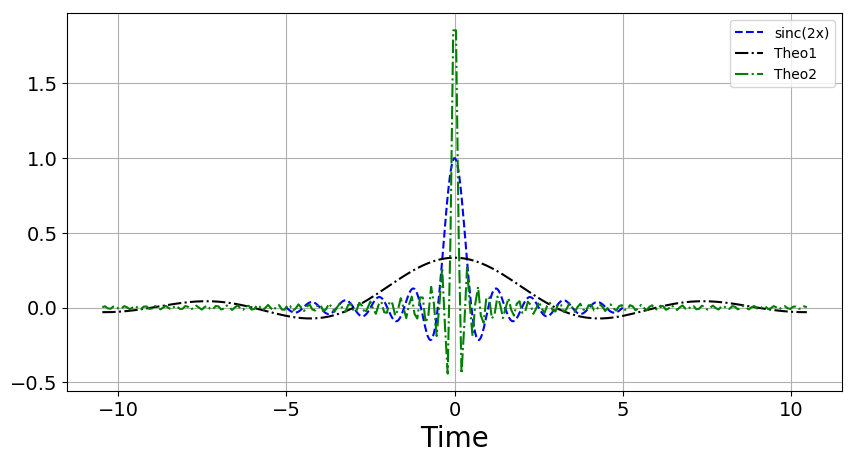

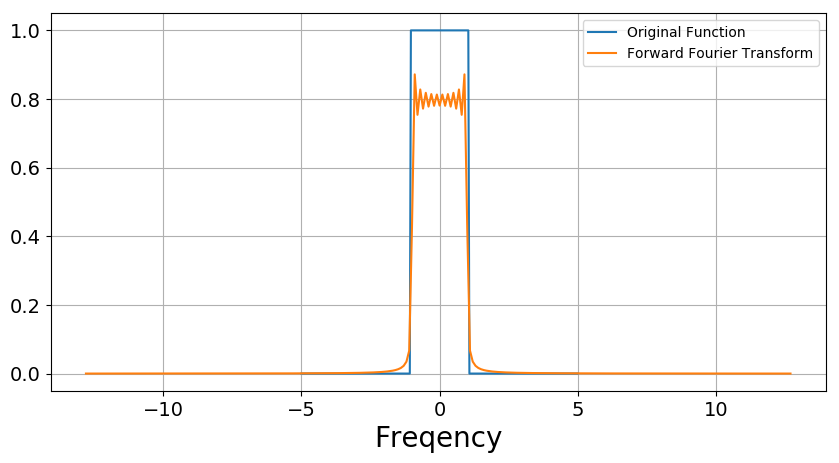

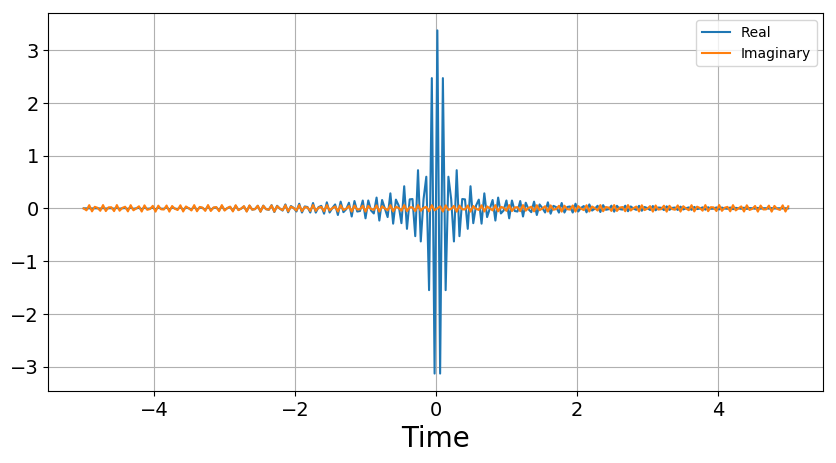

In [4]:
def X(omega, box_bounds=(np.pi/3)):
    y = np.zeros(omega.shape) 
    y[np.abs(omega) <= box_bounds] = 1
    return y

def analytic_x(t, N):
    return np.exp(1j*np.pi*t*(1-1/N))*np.sin(np.pi*t)/np.sin(np.pi*t/N)/N

def fn1(n):
    return np.sin(n*np.pi/3)/n/np.pi

def fn2(n):
    return np.sinc(2*n*(np.pi**2)/3)*2*np.pi/3

N = 2**8
x = np.linspace(-5, 5, N)
n = np.linspace(-10*np.pi/3, 10*np.pi/3, N)
f = X(x)
time_domain = np.fft.ifft(f, norm='ortho')
fourier = np.fft.fft(np.sinc(2*x), norm='ortho')

plot = make_plot(x_label='Time')
#plot.plot(x, analytic_x(x, N).real, 'r.-', label='Analytic')
plot.plot(x, np.sinc(2*x), 'b--', label="sinc(2x)")
plot.plot(n, fn1(n), 'k-.', label="Theo1")
plot.plot(n, fn2(n), 'g-.', label="Theo2")
plot.legend()

plot = make_plot(x_label='Freqency')
plot.plot(x, f, label="Original Function")
plot.plot(np.fft.fftshift(np.fft.fftfreq(len(fourier), d=10/N)), np.fft.fftshift(np.abs(fourier)), label="Forward Fourier Transform")
plot.legend()

plot = make_plot(x_label='Time')
plot.plot(x, np.fft.fftshift(time_domain.real), label='Real')
plot.plot(x, np.fft.fftshift(time_domain.imag), label='Imaginary')
plot.legend();

The theoretical numpy FFT doesn't give the expected function due to what I believe is normalization errors. It is highly dependent on the number of points input, which should not be the case.

In [5]:
def twoD_map(fn, matrix, args=()):
    '''
    Fills a square, 2D matrix with a function
    '''
    width, height = matrix.shape
    
    for w in range(width):
        for h in range(height):
            matrix[w, h] = fn(w, h, *args)
    
    return matrix
            
def DFT_matrix(n, m, N):
    return np.exp(-1j*2*np.pi*n*m/N)

def IDFT_matrix(n, m, N):
    return np.exp(1j*2*np.pi*n*m/N)/N

N = 3
f = twoD_map(DFT_matrix, np.zeros((N, N), dtype=np.complex), args=(N,))
i = twoD_map(IDFT_matrix, np.zeros((N, N), dtype=np.complex), args=(N,))

print("Forward:\n", f), print("Inverse:\n", i), print("Dot Product:\n", np.round(np.dot(i, f), 8));

Forward:
 [[ 1.0+0.j         1.0+0.j         1.0+0.j       ]
 [ 1.0+0.j        -0.5-0.8660254j -0.5+0.8660254j]
 [ 1.0+0.j        -0.5+0.8660254j -0.5-0.8660254j]]
Inverse:
 [[ 0.33333333+0.j          0.33333333+0.j          0.33333333+0.j        ]
 [ 0.33333333+0.j         -0.16666667+0.28867513j -0.16666667-0.28867513j]
 [ 0.33333333+0.j         -0.16666667-0.28867513j -0.16666667+0.28867513j]]
Dot Product:
 [[ 1.+0.j -0.-0.j  0.-0.j]
 [-0.+0.j  1.-0.j -0.-0.j]
 [ 0.+0.j -0.+0.j  1.+0.j]]


In [6]:
N = 4
f_N4 = twoD_map(DFT_matrix, np.zeros((N, N), dtype=np.complex), args=(N,))
x = np.array([1,0,-1,0]).T

print(f_N4), print(np.dot(f_N4, x));

[[  1.00000000e+00 +0.00000000e+00j   1.00000000e+00 +0.00000000e+00j
    1.00000000e+00 +0.00000000e+00j   1.00000000e+00 +0.00000000e+00j]
 [  1.00000000e+00 +0.00000000e+00j   6.12323400e-17 -1.00000000e+00j
   -1.00000000e+00 -1.22464680e-16j  -1.83697020e-16 +1.00000000e+00j]
 [  1.00000000e+00 +0.00000000e+00j  -1.00000000e+00 -1.22464680e-16j
    1.00000000e+00 +2.44929360e-16j  -1.00000000e+00 -3.67394040e-16j]
 [  1.00000000e+00 +0.00000000e+00j  -1.83697020e-16 +1.00000000e+00j
   -1.00000000e+00 -3.67394040e-16j   5.51091060e-16 -1.00000000e+00j]]
[ 0. +0.00000000e+00j  2. +1.22464680e-16j  0. -2.44929360e-16j
  2. +3.67394040e-16j]


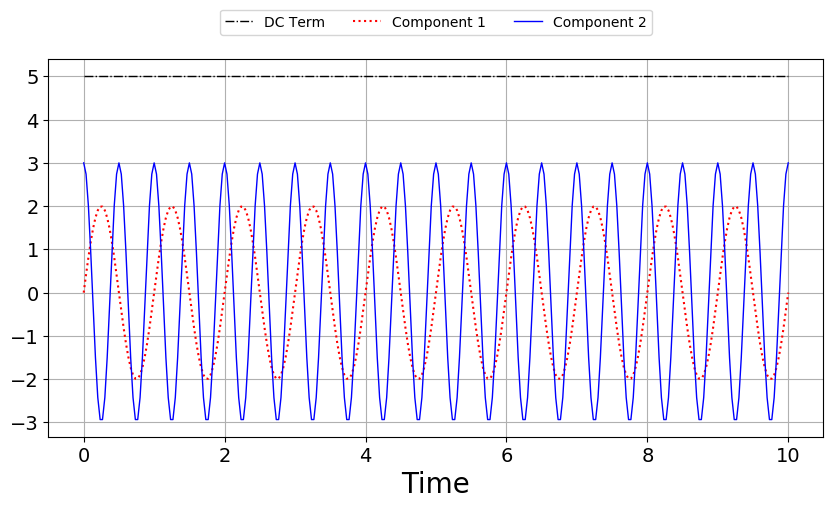

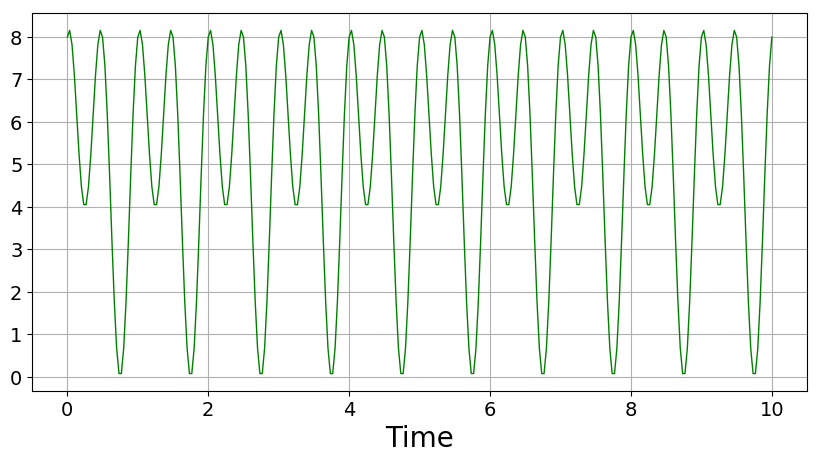

In [7]:
def signal_11(x):
    return 5 + 2*np.cos(2*np.pi*x-np.pi/2) + 3*np.cos(4*np.pi*x)

x = np.linspace(0, 10, 301)
line_width  = 1

plot = make_plot(x_label='Time')
plot.plot(x, np.ones(len(x))*5, 'k-.', label='DC Term', linewidth=line_width)
plot.plot(x, 2*np.cos(2*np.pi*x-np.pi/2), 'r:', label='Component 1', linewidth=1.5*line_width)
plot.plot(x, 3*np.cos(4*np.pi*x), 'b-', label='Component 2', linewidth=line_width)
plot.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3);

plot = make_plot(x_label='Time')
plot.plot(x, signal_11(x), 'g-', label='Total Signal', linewidth=line_width);

[ 8.+0.j  4.+0.j  8.+0.j  0.+0.j]
[[  1.00000000e+00 +0.00000000e+00j   1.00000000e+00 +0.00000000e+00j
    1.00000000e+00 +0.00000000e+00j   1.00000000e+00 +0.00000000e+00j]
 [  1.00000000e+00 +0.00000000e+00j   6.12323400e-17 -1.00000000e+00j
   -1.00000000e+00 -1.22464680e-16j  -1.83697020e-16 +1.00000000e+00j]
 [  1.00000000e+00 +0.00000000e+00j  -1.00000000e+00 -1.22464680e-16j
    1.00000000e+00 +2.44929360e-16j  -1.00000000e+00 -3.67394040e-16j]
 [  1.00000000e+00 +0.00000000e+00j  -1.83697020e-16 +1.00000000e+00j
   -1.00000000e+00 -3.67394040e-16j   5.51091060e-16 -1.00000000e+00j]]
[ 1.5+0.j  -0.5+0.5j -0.5-0.j  -0.5-0.5j]
[ 1.5         0.70710678  0.5         0.70710678]


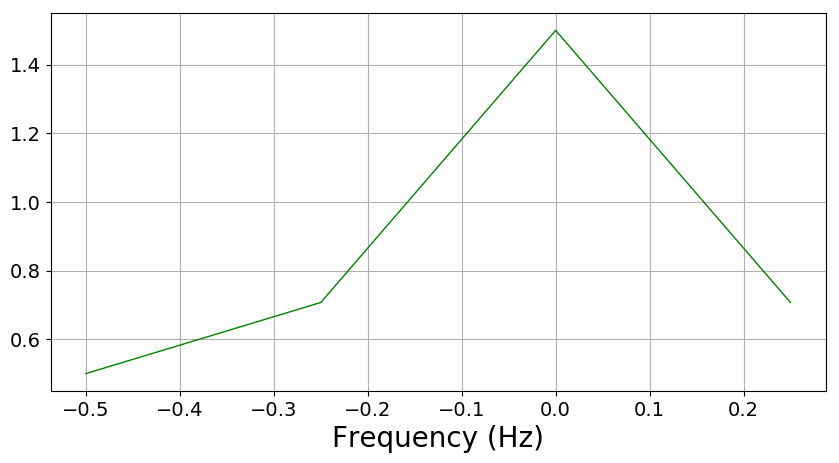

In [8]:
x = np.arange(0, 1, 1/4, dtype=np.complex).T
line_width  = 1
fourier_transform = np.dot(f_N4, x)

print(signal_11(x)), print(f_N4), print(np.round(fourier_transform, 4)), print(np.abs(np.round(fourier_transform, 4)));

plot = make_plot(x_label='Frequency (Hz)')
plot.plot(np.fft.fftshift(np.fft.fftfreq(len(x))), np.fft.fftshift(np.abs(fourier_transform)), 'g-', label='Total Signal', linewidth=line_width);

### 1.2 Power spectrum and filtering

$V_j = A\sin(2\pi f t_j - \phi)$

In [13]:
def funcVj(A, tj, f, phi):
    
    return A*np.sin(2*np.pi*f*tj+phi)

The total power is,

$$P = \sum_0^N V_j^2 = A^2\sum_0^N \sin^2(2\pi f t_j - \phi)$$

Let $\Delta t = L/N$ 

So $t_j = idt$ and $V_j = A\sin^2(2\pi f \times i\frac{L}{N} - \phi)$, where $i$ in an integer.

For the $N^{th}$ point ($i=N$), $V_j = A\sin^2(2\pi f \times N\frac{L}{N} - \phi) = A\sin^2(2\pi f \times L- \phi) $

If $L=\frac{m}{f}$,where m is any positive integer, $A\sin^2(2\pi f \times L- \phi) =A\sin^2(2m\pi- \phi)$, which means the function completes a period on the final point, no matter which value of m is chosen. 

The average of any sequence is $average = \frac{\sum xi}{N}$, which means that $\sum xi = N \times average$.

The average value of $\sin^2(x)$ over any number of periods is $<\sin^2(x)>=\frac{1}{2}$, this means that the sum,

$$\sum_0^N \sin^2(2\pi f t_j - \phi) = N\times average = \frac{N}{2}$$

Thus, the total power is $A^2\sum_0^N \sin^2(2\pi f t_j - \phi)= A^2\frac{N}{2}$


The frequencies are $f_i = i\frac{1}{N\Delta t} = i\frac{1}{L} = i\frac{f}{m}$. This means that the fundamental frequency of our transformed sine function, f, will be completly represented by a single bin in frequency space when $i=m$.

In [336]:
def powerVj(N, L, f, A, xlims = None, return_type = 'freq', plot=True, plot_stacked=False):

    dt = L/N
    tj = np.array([dt*n for n in range(N)])

    Vj = funcVj(A, tj, f, 0)

    tVj = np.fft.fft(Vj, norm='ortho')
    freq = np.fft.fftfreq(N, d=dt)
    
    order = np.argsort(freq)
    tVj =  tVj[order]
    freq = freq[order]
    
    if plot:
        
        if plot_stacked:
            fig, ax = plt.subplots(3,1, figsize=(8,10))
        else:
            fig, ax = plt.subplots(1,3, figsize=(15,5))
    
        ax[0].plot(tj, Vj, '-o')
        ax[0].grid('on')
        ax[0].set_xlabel('time $t_j$', fontsize=20)
        ax[0].set_ylabel('$V_j$', fontsize=20)
        ax[0].tick_params(labelsize=20)
        
    
        ax[1].plot(freq, np.abs(tVj)**2, '-o')
        ax[1].grid('on')
        ax[1].set_xlabel('frequency $f_j$', fontsize=20)
        ax[1].set_ylabel('Power', fontsize=20)
        ax[1].tick_params(labelsize=20)
        
        ax[2].plot(freq, np.abs(tVj)**2, '-o')
        ax[2].grid('on')
        ax[2].set_xlabel('frequency $f_j$', fontsize=20)
        ax[2].set_ylabel('Power', fontsize=20)
        ax[2].tick_params(labelsize=20)
        ax[2].set_yscale('log')
        ax[2].set_ylabel('Power (log scale)', fontsize=20)
        
        if xlims is not None:
            ax[1].set_xlim(-xlims,xlims)
            ax[2].set_xlim(-xlims,xlims)
                
        plt.tight_layout()
    
        print("Total power by calculating the sum of Vj^2:", np.sum(Vj**2))
        print("Total power by calculating the sum of fft(Vj)^2/N:", np.sum(np.abs(tVj)**2)/(N))

        print("A*A*N/2:", A*A*(N)/2)
    
    if return_type == 'freq':
        return freq, np.abs(tVj)**2
    else:
        return tj, Vj

Total power by calculating the sum of Vj^2: 12500.0
Total power by calculating the sum of fft(Vj)^2/N: 50.0
A*A*N/2: 12500.0


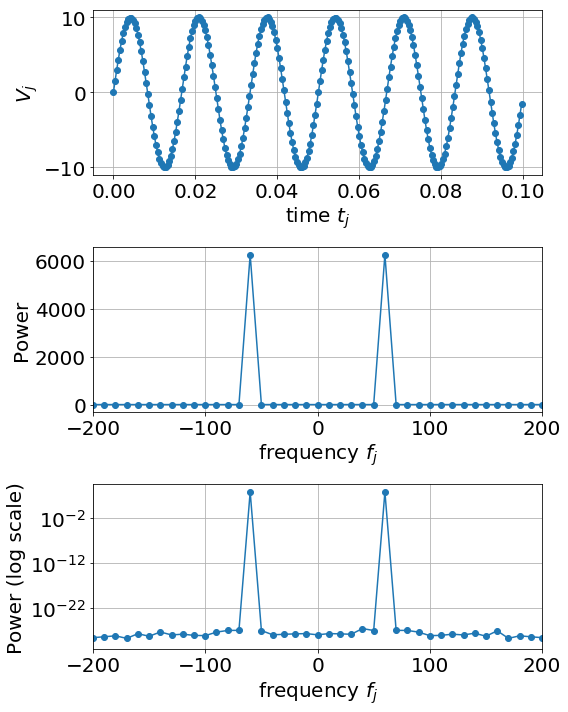

In [343]:
f = 60
L = 6/60
N = 250
A = 10

powerVj(N, L, f, A, plot_stacked=True, xlims=200);

If the function is not perfectly sampled:
* The signal will not complete a full period in time space by the end of the sequence ($j=N$). As a result, the FFT, which always expects a periodic signal, will not show the transform for a perfect sine function as expected, but will also offer additional frequencies in order to best represent the transform of a discontinous repeating function. Some of the power will "leak" to other frequencies. This is called spectral leakage.

Total power by calculating the sum of Vj^2: 12564.0056637
Total power by calculating the sum of fft(Vj)^2/N: 50.2560226547
A*A*N/2: 12500.0


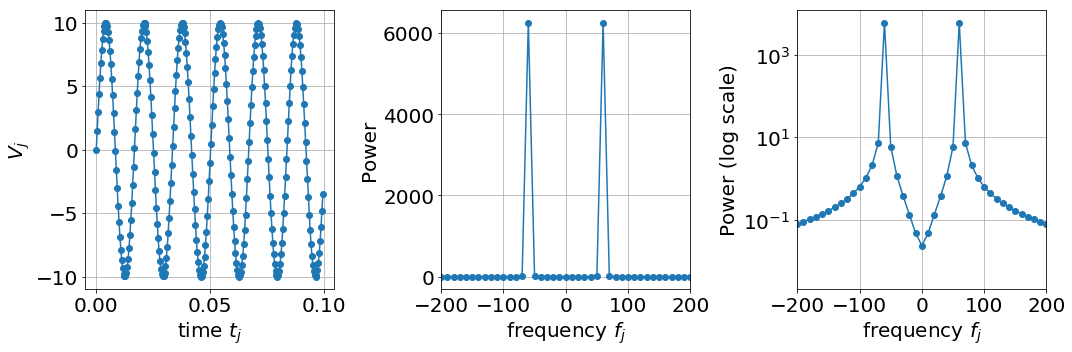

In [342]:
f = 59.673
L = 6/60
N = 250
A = 10

tj, Vj = powerVj(N, L, f, A, plot_stacked=False, xlims=200, return_type='time');
freq, TVj = powerVj(N, L, f, A, plot=False);


tj_hann = tj

#freq, Pwr = powerVj(250, 1, 59.673, 10, plot_stacked=True, logscale=True)

In [247]:
otherbins = np.where(TVj<TVj.max())

print(np.sum(TVj[otherbins]))
print(np.sum(TVj))
print(np.sum(TVj[otherbins])/np.sum(TVj))

6303.88514552
12564.0056637
0.501741666971


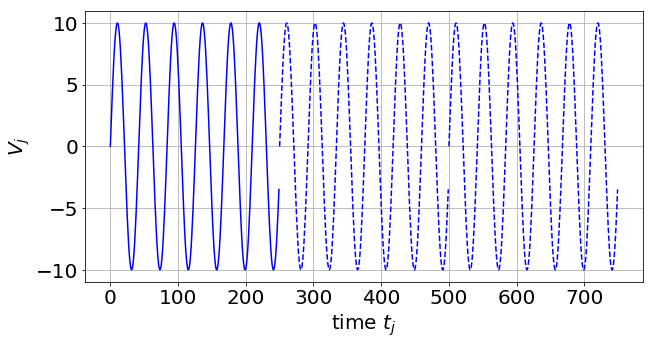

In [648]:
f = 59.673
L = 6/60
N = 250
A = 10

repeat = 3
Vj_repeating = list(Vj)*repeat
dt = tj[1]-tj[0]

tj_repeating = np.array([dt*n for n in range(len(tj)*repeat)])

pure_sine = funcVj(A, tj_repeating, f, 0)

plt.figure(figsize=(10,5))

for n in range(repeat):
    startpoint = n*len(Vj)
    endpoint = startpoint + len(Vj)
    if n==0:
        plt.plot(tj_repeating[startpoint:endpoint], Vj, 'b-')
    else: 
        plt.plot(tj_repeating[startpoint:endpoint], Vj, 'b--')
        

#plt.plot(tj_repeating, pure_sine, 'r-')
plt.grid('on')
plt.xlabel('time $t_j$', fontsize=20)
plt.ylabel('$V_j$', fontsize=20)
#plt.xlim(tj_repeating[-500], tj_repeating[-1])
plt.tick_params(labelsize=20);


* The fundamental freqency might not exist in the frequency sampling and due to this, the power of the transformed sine function's delta spike will be spread across more than one bin.  

df= 0.2040816326530612 frequencies represented
4.693877551020408
4.897959183673469
5.10204081632653
5.3061224489795915
...


Total power by calculating the sum of Vj^2: 5000.0
Total power by calculating the sum of fft(Vj)^2/N: 50.0
A*A*N/2: 5000.0


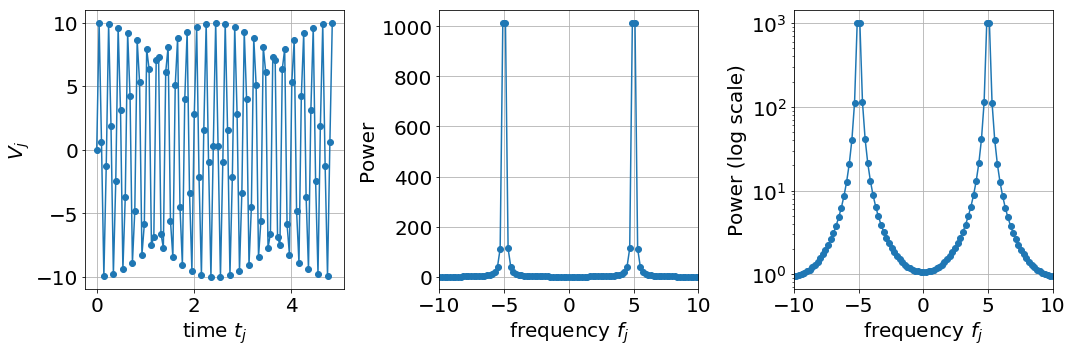

In [574]:
f = 5
L = 4.9

deltaf = 1/L

print('df=',deltaf,'frequencies represented')
for i in range(23,27):
    print(deltaf*i)

print('...\n\n')
N = 100
A = 10

powerVj(N, L, f, A, xlims = 10);

In [189]:
def Hann_function(n,N):
    
    return 0.5*(1 - np.cos(2*np.pi*n/(N-1)))
    

In [324]:
def filter(window_function, tj, signal, xlim):
    
    n = np.arange(len(tj))
    H = window_function(n, len(tj))
    
    signal = H*signal
    Tsignal = np.fft.fft(signal, norm='ortho')
    freq = np.fft.fftfreq(len(tj), d=(tj[1]-tj[0]))
    order = np.argsort(freq)
    freq = freq[order]
    Tsignal = Tsignal[order]

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    
    ax[0].plot(tj, signal, '-o')
    ax[0].grid('on')
    ax[0].set_xlabel('time $t_j$', fontsize=20)
    ax[0].set_ylabel('Signal', fontsize=20)
    ax[0].tick_params(labelsize=20)
    
    ax[1].plot(freq, np.abs(Tsignal)**2, '-o')
    ax[1].grid('on')
    ax[1].set_xlabel('frequency $f_j$', fontsize=20)
    ax[1].set_ylabel('Power', fontsize=20)
    #ax[1].set_yscale('log')
    ax[1].set_xlim(-xlim, xlim)
    ax[1].tick_params(labelsize=20)
    
    
    ax[2].plot(freq, np.abs(Tsignal)**2, '-o')
    ax[2].grid('on')
    ax[2].set_xlabel('frequency $f_j$', fontsize=20)
    ax[2].set_ylabel('Power (log scale)', fontsize=20)
    #ax[1].set_yscale('log')
    ax[2].set_xlim(-xlim, xlim)
    ax[2].tick_params(labelsize=20)
    ax[2].set_yscale('log')
    
    plt.tight_layout()

    print("Total power:", np.sum(signal**2))
    
    return np.abs(Tsignal)**2

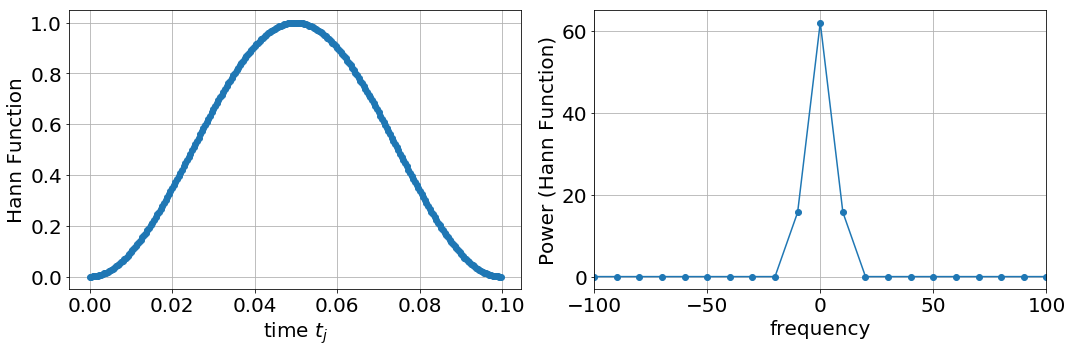

In [349]:
tj = np.arange(len(tj_hann))
N = 250
H = Hann_function(tj, N)

TH = np.fft.fft(H, norm='ortho')
freq = np.fft.fftfreq(len(tj), d=(tj_hann[1]-tj_hann[0]))
order = np.argsort(freq)
freq = freq[order]
TH = TH[order]

fig, ax = plt.subplots(1,2, figsize=(15,5))
    
ax[0].plot(tj_hann, H, '-o')
ax[0].grid('on')
ax[0].set_xlabel('time $t_j$', fontsize=20)
ax[0].set_ylabel('Hann Function', fontsize=20)
ax[0].tick_params(labelsize=20)
    
ax[1].plot(freq, np.abs(TH)**2, '-o')
ax[1].grid('on')
ax[1].set_xlabel('frequency', fontsize=20)
ax[1].set_ylabel('Power (Hann Function)', fontsize=20)
ax[1].tick_params(labelsize=20)
ax[1].set_xlim(-100,100)

plt.tight_layout()
    

Total power: 4668.75375042
1568.87663014
4668.75375042
0.336037562487


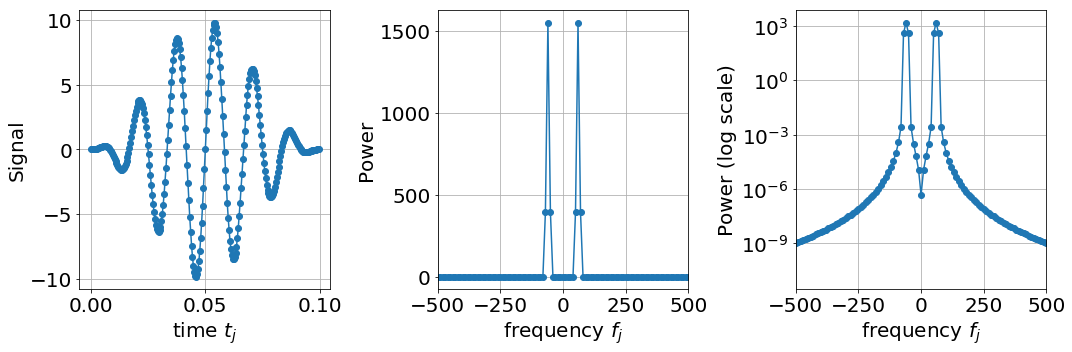

In [338]:
#f = 59.673
f=60
L = 6/60
N = 250
A = 10

tj, Vj = powerVj(N, L, f, A, return_type='time', plot=False)

Pwr = filter(Hann_function, tj, Vj, xlim=500)

otherbins = np.where(Pwr<Pwr.max())

print(np.sum(Pwr[otherbins]))
print(np.sum(Pwr))
print(np.sum(Pwr[otherbins])/np.sum(Pwr))

Total power: 4668.75846987
1573.22278043
4668.75846987
0.33696812345


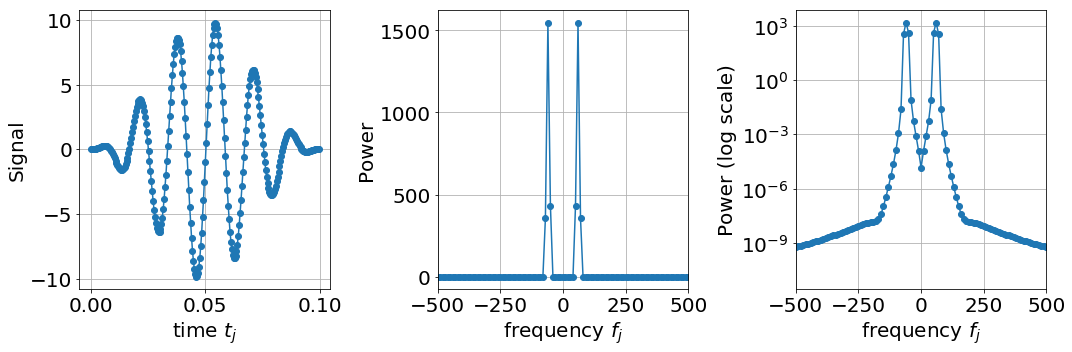

In [339]:
f = 59.673
L = 6/60
N = 250
A = 10

tj, Vj = powerVj(N, L, f, A, return_type='time', plot=False)

Pwr = filter(Hann_function, tj, Vj, xlim=500)

otherbins = np.where(Pwr<Pwr.max())

print(np.sum(Pwr[otherbins]))
print(np.sum(Pwr))
print(np.sum(Pwr[otherbins])/np.sum(Pwr))

In [266]:
def BM_Hn(n, N):
    
    pi = np.pi
    
    a0=0.35875
    a1=0.48829
    a2=0.14128
    a3=0.01168
    
    return a0 - a1*np.cos(2*pi*n/(N-1)) + a2*np.cos(4*pi*n/(N-1)) - a3*np.cos(6*pi*n/(N-1))

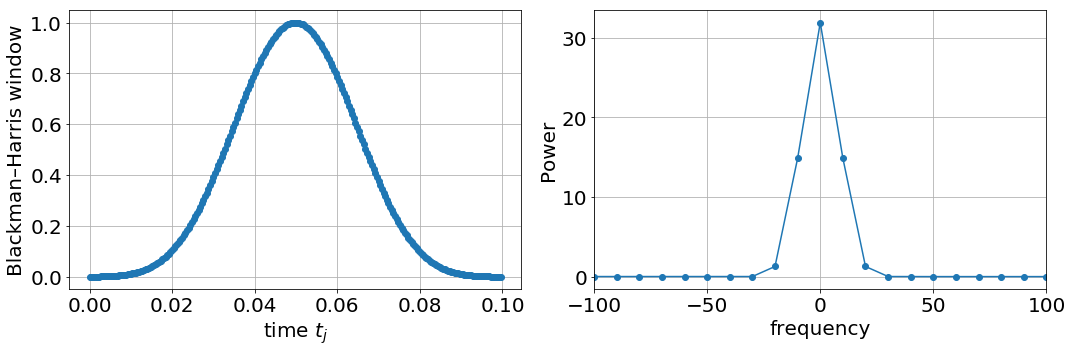

In [348]:
tj = np.arange(250)
N = 250
H = BM_Hn(tj, N)

TH = np.fft.fft(H, norm='ortho')
freq = np.fft.fftfreq(len(tj), d=(tj_hann[1]-tj_hann[0]))
order = np.argsort(freq)
freq = freq[order]
TH = TH[order]

fig, ax = plt.subplots(1,2, figsize=(15,5))
    
ax[0].plot(tj_hann, H, '-o')
ax[0].grid('on')
ax[0].set_xlabel('time $t_j$', fontsize=20)
ax[0].set_ylabel('Blackman–Harris window', fontsize=20)
ax[0].tick_params(labelsize=20)
    
ax[1].plot(freq, np.abs(TH)**2, '-o')
ax[1].grid('on')
ax[1].set_xlabel('frequency', fontsize=20)
ax[1].set_ylabel('Power', fontsize=20)
ax[1].tick_params(labelsize=20)
ax[1].set_xlim(-100,100)
    
plt.tight_layout()
    

Total power: 3211.64377365
1615.7220623
3211.64377365
0.503082588287


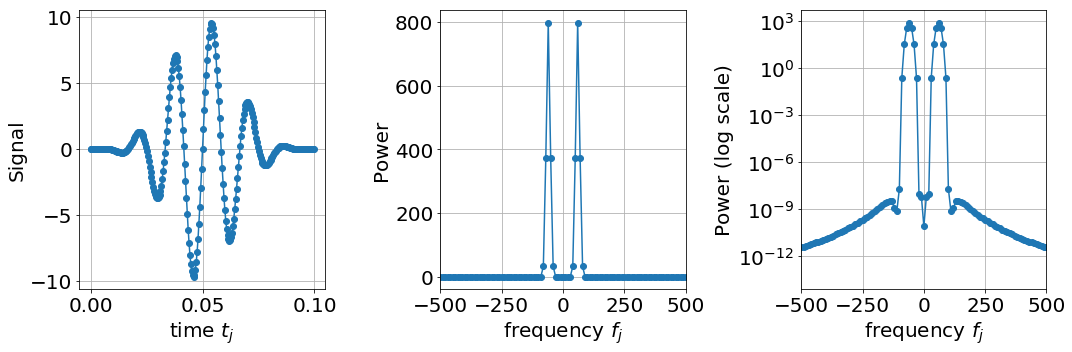

In [340]:
f = 60
L = 6/60
N = 250
A = 10

tj, Vj = powerVj(N, L, f, A, return_type='time', plot=False)

Pwr = filter(BM_Hn, tj, Vj, xlim=500)

otherbins = np.where(Pwr<Pwr.max())

print(np.sum(Pwr[otherbins]))
print(np.sum(Pwr))
print(np.sum(Pwr[otherbins])/np.sum(Pwr))

Total power: 3211.64377934
1617.00561875
3211.64377934
0.503482244559


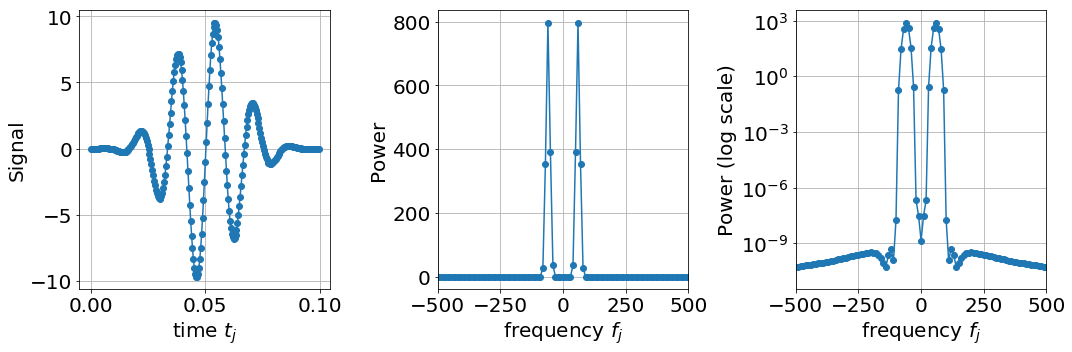

In [341]:
f = 59.673
L = 6/60
N = 250
A = 10

tj, Vj = powerVj(N, L, f, A, return_type='time', plot=False)

Pwr = filter(BM_Hn, tj, Vj, xlim=500);

otherbins = np.where(Pwr<Pwr.max())

print(np.sum(Pwr[otherbins]))
print(np.sum(Pwr))
print(np.sum(Pwr[otherbins])/np.sum(Pwr))

## 2. General Applications

### 2.1 A stellar binary system

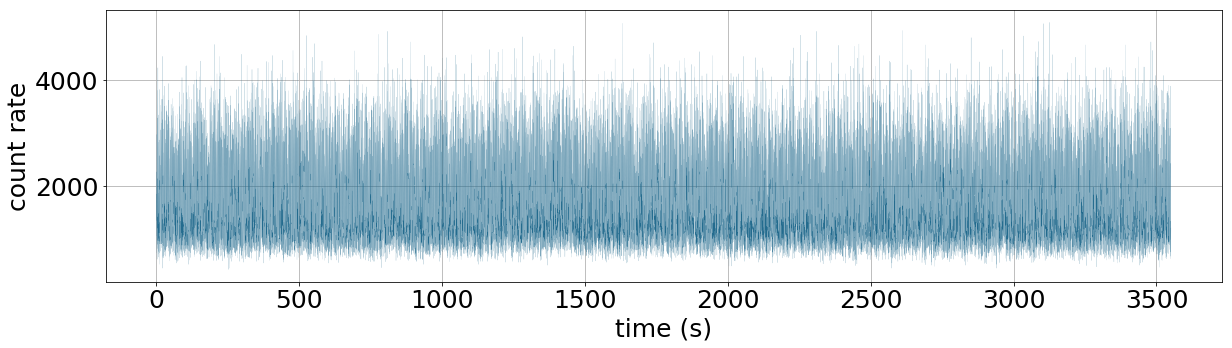

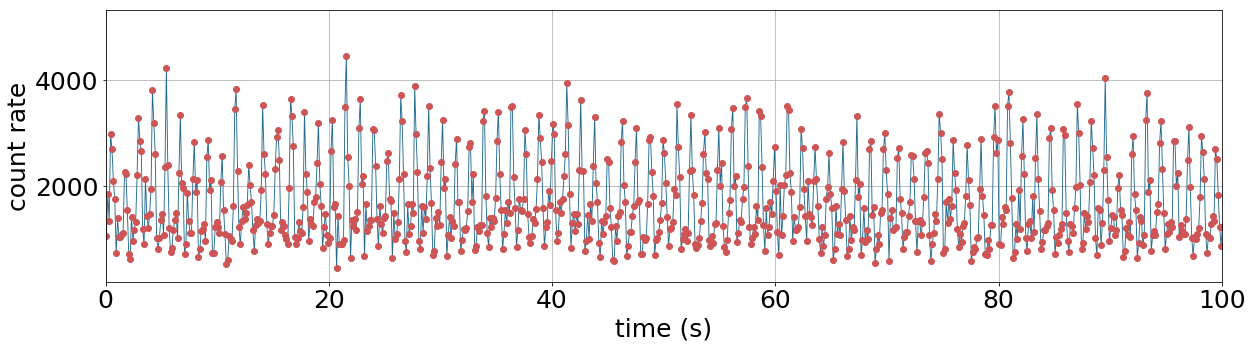

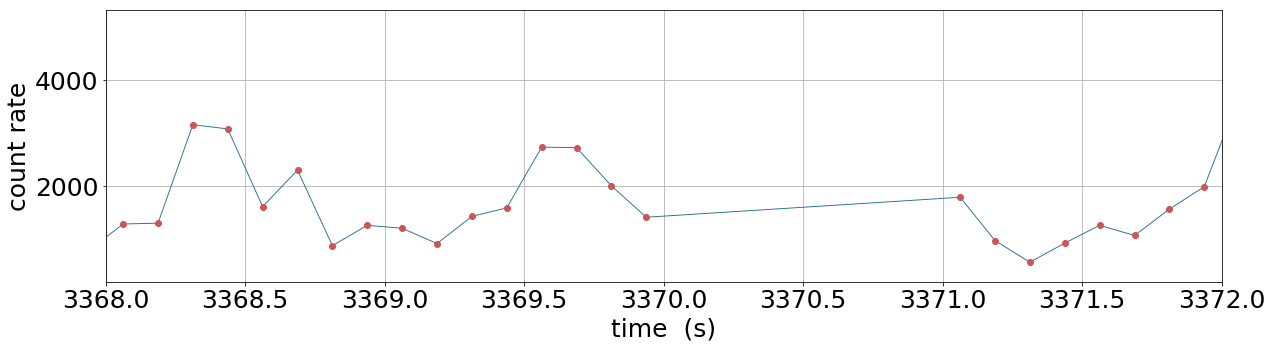

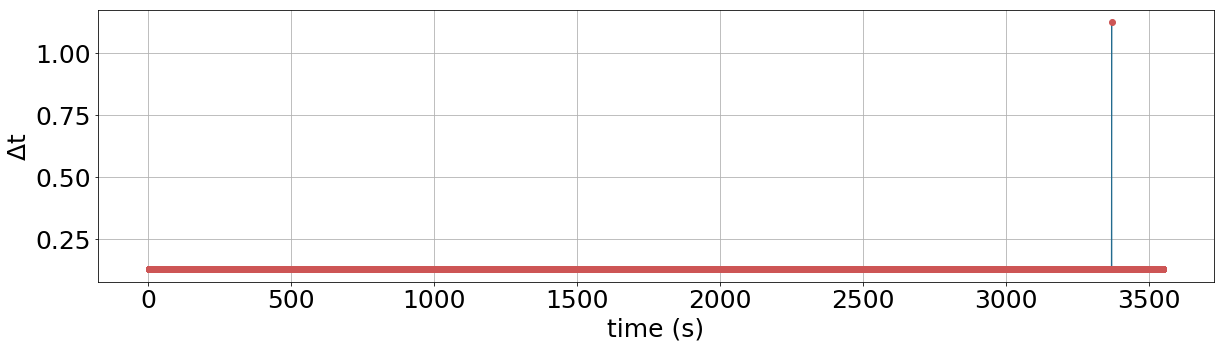

In [389]:
url = 'assign2/phys581-binary.txt'
data = np.genfromtxt( url, usecols=(0,1), names=['time', 'count_rate'] )

t = data['time']
CR = data['count_rate']

plt.figure(figsize=(20,5))
plt.plot(t, CR, color='#236B8E', linestyle='solid',  linewidth=0.1);
plt.grid('on')
plt.xlabel('time (s)', fontsize=25)
plt.tick_params(labelsize=25)
plt.ylabel('count rate', fontsize=25);
plt.show()

plt.figure(figsize=(20,5))
plt.plot(t, CR, color='#236B8E', linestyle='solid', marker='o',
               markerfacecolor='#CD5555',markeredgecolor='#CD5555', markersize=6, linewidth=0.9);
plt.grid('on')
plt.xlabel('time (s)', fontsize=25)
plt.tick_params(labelsize=25)
plt.xlim(0,100)
plt.ylabel('count rate', fontsize=25);
plt.show()

plt.figure(figsize=(20,5))
plt.plot(t, CR, color='#236B8E', linestyle='solid', marker='o',
               markerfacecolor='#CD5555',markeredgecolor='#CD5555', markersize=6, linewidth=0.9);
plt.grid('on')
plt.xlabel('time  (s)', fontsize=25)
plt.tick_params(labelsize=25)
plt.xlim(3368,3372)
plt.ylabel('count rate', fontsize=25);
plt.show()

dt = t[1:] - np.roll(t,1)[1:]

t[np.where(dt == dt.max())]

plt.figure(figsize=(20,5))
plt.plot(t[1:], dt, color='#236B8E', linestyle='solid', marker='o',
               markerfacecolor='#CD5555',markeredgecolor='#CD5555', markersize=6, linewidth=1);
plt.grid('on')
plt.xlabel('time (s)', fontsize=25)
plt.tick_params(labelsize=25)
#plt.xlim(3368,3372)
plt.ylabel('$\Delta$t', fontsize=25);

In [575]:
TCR = np.fft.fft(count_rate, norm='ortho')
freq = np.fft.fftfreq(len(t), d=(t[1]-t[0]))
order = np.argsort(freq)
freq=freq[order]
                    
indices = np.where(t<3369)

time = t[indices]
count_rate = CR[indices]
dt = time[1]-time[0]

TCR = np.fft.fft(count_rate, norm='ortho')
freq = np.fft.fftfreq(len(time), d=(dt))
order = np.argsort(freq)
freq=freq[order]
                      

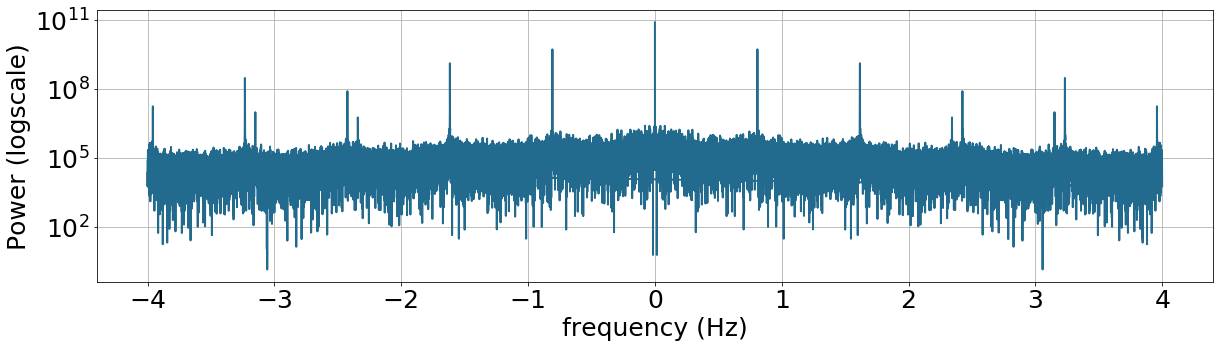

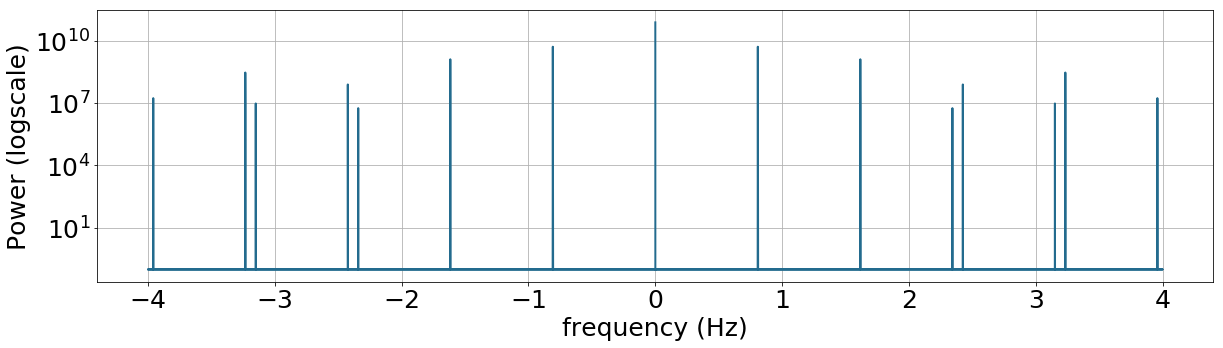

In [576]:
indices = np.where(t<3369)

time = t[indices]
count_rate = CR[indices]
dt = time[1]-time[0]

TCR = np.fft.fft(count_rate, norm='ortho')
freq = np.fft.fftfreq(len(time), d=dt)
TCRpr= np.abs(TCR)**2

plt.figure(figsize=(20,5))
plt.plot(freq, TCRpr, color='#236B8E', linestyle='solid', linewidth=2);
plt.grid('on')
plt.xlabel('frequency (Hz)', fontsize=25)
plt.ylabel('Power (logscale)', fontsize=25)
plt.tick_params(labelsize=25)
plt.yscale('log')

plt.show()

TCRpr[np.where(np.abs(TCRpr)<5e6)] = 0.1
TCR[np.where(np.abs(TCRpr)<5e6)] = 0

plt.figure(figsize=(20,5))
plt.plot(freq, TCRpr, color='#236B8E', linestyle='solid', linewidth=2);
plt.grid('on')
plt.xlabel('frequency (Hz)', fontsize=25)
plt.ylabel('Power (logscale)', fontsize=25)
plt.tick_params(labelsize=25)
plt.yscale('log')

plt.show()


In [518]:
freqsorted = freq[order]
TCRpr = TCRpr[order]

In [519]:
TCRpr = TCRpr[np.where(freqsorted>0)]
freqsorted = freqsorted[np.where(freqsorted>0)]

In [529]:
Max = (1000,5000)
Ind_max = TCRpr[Max[0]:Max[1]].argmax() + Max[0]
print("Max:", TCRpr[Ind_max], "| Index:", Ind_max, "| Period:", 1/freqsorted[Ind_max], "| Frequency:", freq[Ind_max])

Max = (4000,6000)
Ind_max = TCRpr[Max[0]:Max[1]].argmax() + Max[0]
print("Max:", TCRpr[Ind_max], "| Index:", Ind_max, "| Period:", 1/freqsorted[Ind_max], "| Frequency:", freq[Ind_max])

Max = (6000,8000)
Ind_max = TCRpr[Max[0]:Max[1]].argmax() + Max[0]
print("Max:", TCRpr[Ind_max], "| Index:", Ind_max, "| Period:", 1/freqsorted[Ind_max], "| Frequency:", freq[Ind_max])

Max = (8000,10000)
Ind_max = TCRpr[Max[0]:Max[1]].argmax() + Max[0]
print("Max:", TCRpr[Ind_max], "| Index:", Ind_max, "| Period:", 1/freqsorted[Ind_max], "| Frequency:", freq[Ind_max])

Max = (10000,10750)
Ind_max = TCRpr[Max[0]:Max[1]].argmax() + Max[0]
print("Max:", TCRpr[Ind_max], "| Index:", Ind_max, "| Period:", 1/freqsorted[Ind_max], "| Frequency:", freq[Ind_max])

Max = (10750,11000)
Ind_max = TCRpr[Max[0]:Max[1]].argmax() + Max[0]
print("Max:", TCRpr[Ind_max], "| Index:", Ind_max, "| Period:", 1/freqsorted[Ind_max], "| Frequency:", freq[Ind_max])

Max = (13300,13400)
Ind_max = TCRpr[Max[0]:Max[1]].argmax() + Max[0]
print("Max:", TCRpr[Ind_max], "| Index:", Ind_max, "| Period:", 1/freqsorted[Ind_max], "| Frequency:", freq[Ind_max])


Max: 5149084189.61 | Index: 2722 | Period: 1.23723780558 | Frequency: 0.807955231791
Max: 1280299926.25 | Index: 5445 | Period: 0.61861890279 | Frequency: 1.61620728769
Max: 5719832.98111 | Index: 7891 | Period: 0.42688780342 | Frequency: 2.34223906468
Max: 78791477.9928 | Index: 8168 | Period: 0.41241260186 | Frequency: 2.4244593436
Max: 9609167.00826 | Index: 10614 | Period: 0.317380927423 | Frequency: 3.15049112058
Max: 294979836.405 | Index: 10891 | Period: 0.309309451395 | Frequency: 3.2327113995
Max: 17309148.4103 | Index: 13336 | Period: 0.252605424353 | Frequency: 3.95844635238


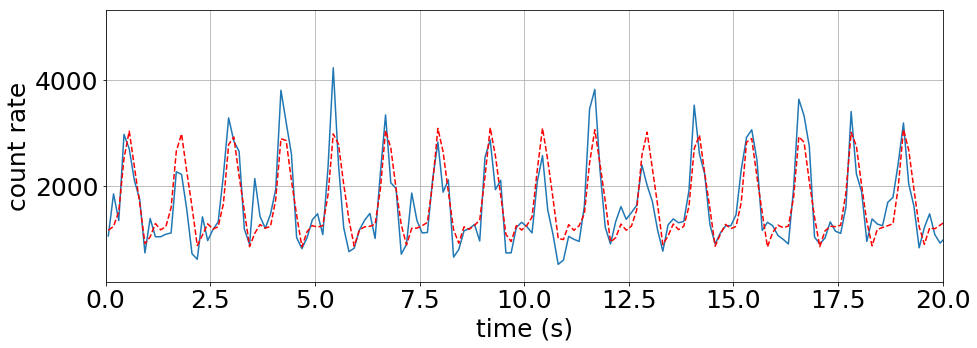

In [562]:
CR_clean = np.fft.ifft(TCR, norm='ortho')

plt.figure(figsize=(15,5))
plt.plot(time, count_rate);
plt.plot(time, CR_clean.real, 'r--');

plt.grid('on')
plt.xlabel('time (s)', fontsize=25)
plt.tick_params(labelsize=25)
plt.xlim(0,20)
plt.ylabel('count rate', fontsize=25);

In [29]:
import astropy.stats as stats

In [543]:
url = 'assign2/phys581-binary.txt'
data = np.genfromtxt( url, usecols=(0,1), names=['time', 'count_rate'] )

t = data['time']
CR = data['count_rate']

frequency, power = stats.LombScargle(t, CR).autopower(method='chi2',maximum_frequency=4, minimum_frequency=0.01, normalization='psd')

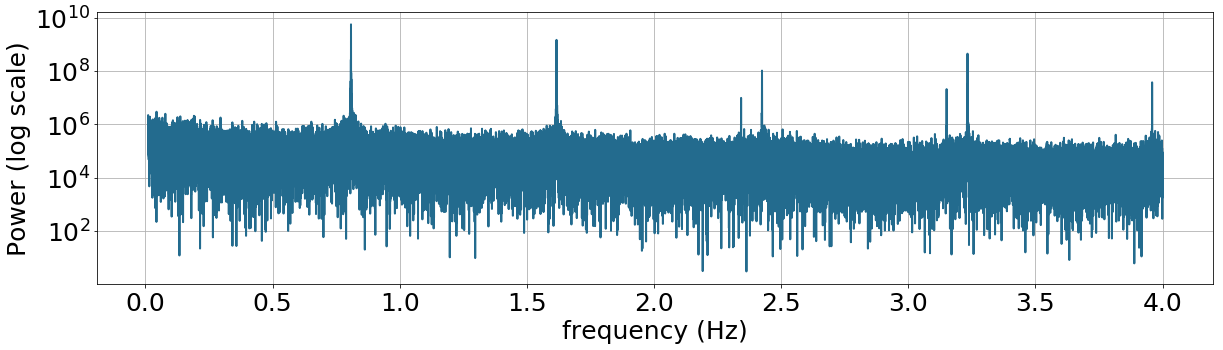

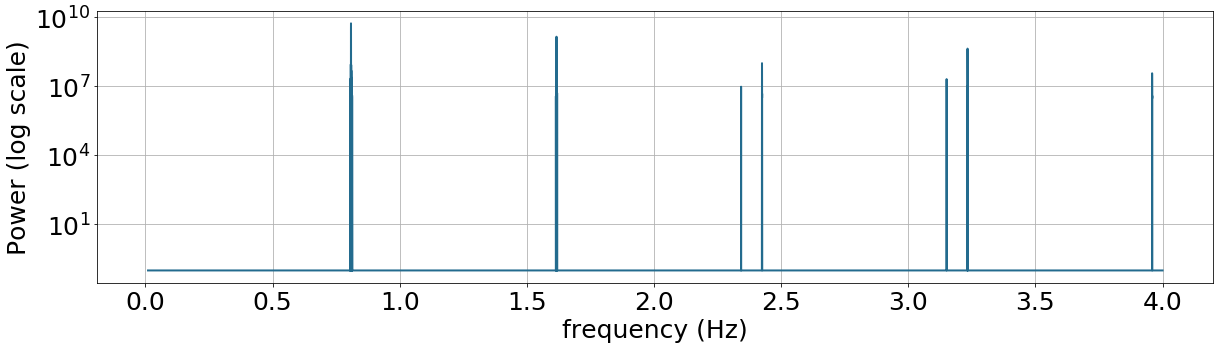

In [577]:
plt.figure(figsize=(20,5))
plt.plot(frequency, power, color='#236B8E', linestyle='solid', linewidth=2);
plt.grid('on')
plt.xlabel('frequency (Hz)', fontsize=25)
plt.ylabel('Power (log scale)', fontsize=25)
plt.tick_params(labelsize=25)
plt.yscale('log')
plt.show()

power_cln = power.copy()

power_cln[np.where(power<3e6)]=0.1

plt.figure(figsize=(20,5))
plt.plot(frequency, power_cln, color='#236B8E', linestyle='solid', linewidth=2);
plt.grid('on')
plt.xlabel('frequency (Hz)', fontsize=25)
plt.ylabel('Power (log scale)', fontsize=25)
plt.tick_params(labelsize=25)
plt.yscale('log')
plt.show()

frequencies = frequency[np.where(power_cln>1)]
frequencies = frequencies[np.where(frequencies>0)]
powerspikes = power_cln[np.where(frequencies>0)]


In [569]:
Max = (10000,20000)
Ind_max = power_cln[Max[0]:Max[1]].argmax() + Max[0]
print("First max:", power_cln[Ind_max], "| Index:", Ind_max, "| Period:", 1/frequency[Ind_max], "| Frequency:", frequency[Ind_max])
A0 = np.sqrt(power_cln[Ind_max])/2
f0 = frequency[Ind_max]

Max = (20000,40000)
Ind_max = power_cln[Max[0]:Max[1]].argmax() + Max[0]
print("Second max:", power_cln[Ind_max], "| Index:", Ind_max, "| Period:", 1/frequency[Ind_max], "| Frequency:", frequency[Ind_max])
A1 = np.sqrt(power_cln[Ind_max])/2
f1 = frequency[Ind_max]

Max = (40000,42000)
Ind_max = power_cln[Max[0]:Max[1]].argmax() + Max[0]
print("Third max:", power_cln[Ind_max], "| Index:", Ind_max, "| Period:", 1/frequency[Ind_max], "| Frequency:", frequency[Ind_max])
A2 = np.sqrt(power_cln[Ind_max])/2
f2 = frequency[Ind_max]

Max = (42000,44000)
Ind_max = power_cln[Max[0]:Max[1]].argmax() + Max[0]
print("Third max:", power_cln[Ind_max], "| Index:", Ind_max, "| Period:", 1/frequency[Ind_max], "| Frequency:", frequency[Ind_max])
A2 = np.sqrt(power_cln[Ind_max])/2
f2 = frequency[Ind_max]

Max = (50000,56000)
Ind_max = power_cln[Max[0]:Max[1]].argmax() + Max[0]
print("Fourth max:", power_cln[Ind_max], "| Index:", Ind_max, "| Period:", 1/frequency[Ind_max], "| Frequency:", frequency[Ind_max])
A3 = np.sqrt(power_cln[Ind_max])/2
f3 = frequency[Ind_max]

Max = (57000,57500)
Ind_max = power_cln[Max[0]:Max[1]].argmax() + Max[0]
print("Fifth max:", power_cln[Ind_max], "| Index:", Ind_max, "| Period:", 1/frequency[Ind_max], "| Frequency:", frequency[Ind_max])
A4 = np.sqrt(power_cln[Ind_max])/2
f4 = frequency[Ind_max]

Max = (60000, len(power_cln))
Ind_max = power_cln[Max[0]:Max[1]].argmax() + Max[0]
print("Sixth max:", power_cln[Ind_max], "| Index:", Ind_max, "| Period:", 1/frequency[Ind_max], "| Frequency:", frequency[Ind_max])
A5 = np.sqrt(power_cln[Ind_max])/2
f5 = frequency[Ind_max]

First max: 5550386520.14 | Index: 14172 | Period: 1.23727801451 | Frequency: 0.808225789412
Second max: 1456734159.37 | Index: 28521 | Period: 0.61865072858 | Frequency: 1.61642095257
Third max: 9769043.15145 | Index: 41411 | Period: 0.426905426332 | Frequency: 2.34243918751
Third max: 102896321.102 | Index: 42871 | Period: 0.412426843129 | Frequency: 2.42467243987
Fourth max: 20845109.2878 | Index: 55760 | Period: 0.317396399804 | Frequency: 3.15063435067
Fifth max: 442884583.366 | Index: 57220 | Period: 0.309322905479 | Frequency: 3.23286760303
Sixth max: 37425785.4132 | Index: 70110 | Period: 0.252596321523 | Frequency: 3.95888583797


### 2.2  Heart Beats

Padding is not necessary, since the number of points in the sequence is already a power of 2 ($2^{12}$)

In [10]:
folder = 'assign2/'

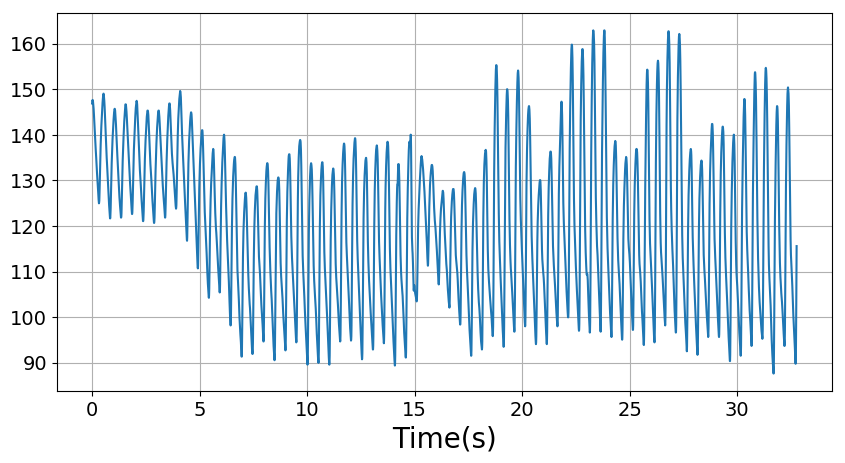

In [11]:
data = np.genfromtxt( folder + 'phys581-beats.txt', usecols=(0), names=['samples'] )
y = data['samples']
x = np.arange(0, 4096/125, 1/125)

make_plot(x_label='Time(s)').plot(x, y);

First max: (13513.3880321-1166.81837513j) | Index: 66 | Period: 0.496484848485 | Frequency: 2.01416015625
Second max: (4602.6589732-3256.75343191j) | Index: 131 | Period: 0.25013740458 | Frequency: 3.99780273438


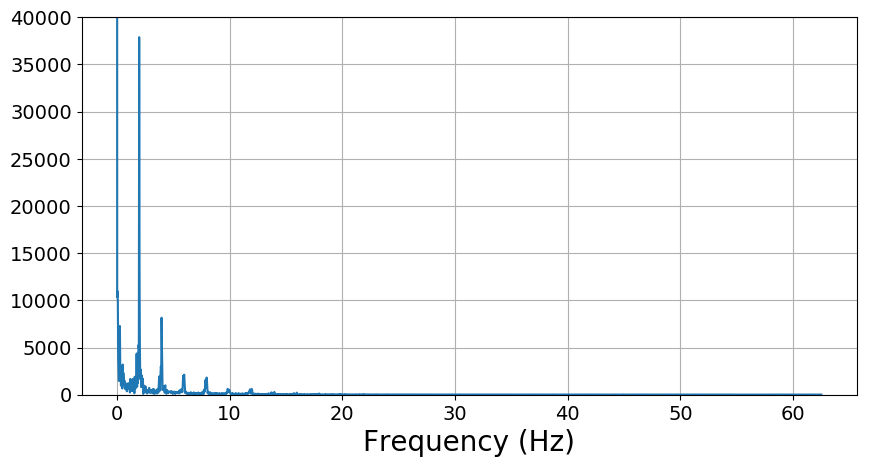

In [13]:
dft_beats = np.fft.rfft(y)
frequencies = np.fft.rfftfreq(len(y), d=1/125)

print("First max:", dft_beats[5:80].max(), "| Index:", dft_beats[5:80].argmax()+5, "| Period:", 1/frequencies[66], "| Frequency:", frequencies[66])
print("Second max:", dft_beats[80:].max(), "| Index:", dft_beats[80:].argmax()+80, "| Period:", 1/frequencies[131], "| Frequency:", frequencies[131])

plot = make_plot(x_label='Frequency (Hz)', y_lim=(-1, 40000))
plot.plot(frequencies, np.abs(dft_beats));

These periods make sense if the person was going for a run or something of the like, where their heartbeat would be approximately 120 beats/minute, as the period is telling us.

### 2.3 Solar Activity

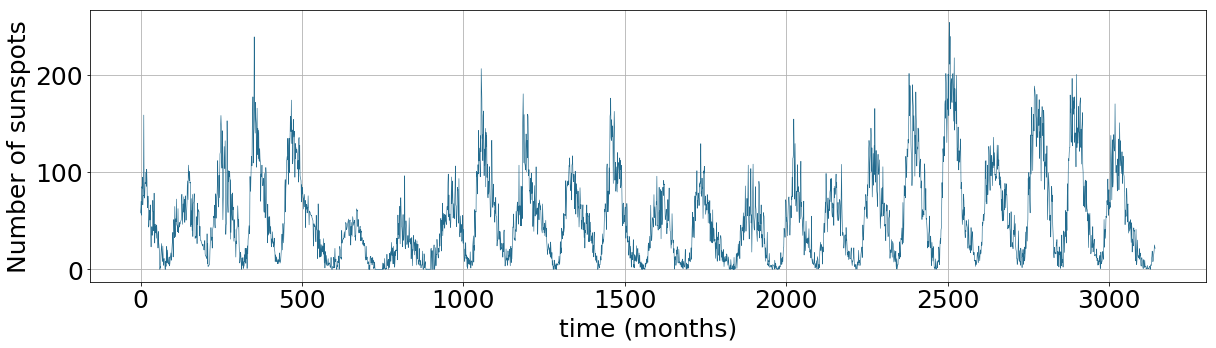

In [649]:
url = 'assign2/phys581-sunspots.txt'
data = np.genfromtxt( url, usecols=(0,1), names=['time', 'count_rate'] )

t = data['time']
CR = data['count_rate']

plt.figure(figsize=(20,5))
plt.plot(t, CR, color='#236B8E', linestyle='solid',  linewidth=0.6);
plt.grid('on')
plt.xlabel('time (months)', fontsize=25)
plt.tick_params(labelsize=25)
plt.ylabel('Number of sunspots', fontsize=25);
plt.show()


In [650]:
print('estimate', 500/4)

estimate 125.0


In [651]:
print('The sun spots data contains',len(CR),'points')
print('The nearest power of 2 is', 2**12)
print('Pad with',2**12-len(CR), 'zeros' )

The sun spots data contains 3143 points
The nearest power of 2 is 4096
Pad with 953 zeros


In [814]:
%timeit np.fft.fft(CR)

1.92 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [584]:
CRpad = np.pad(CR, 953, mode='constant', constant_values = 0)
tpad = np.pad(t, 953, mode='constant', constant_values = 0)
%timeit np.fft.fft(CRpad)

341 µs ± 4.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


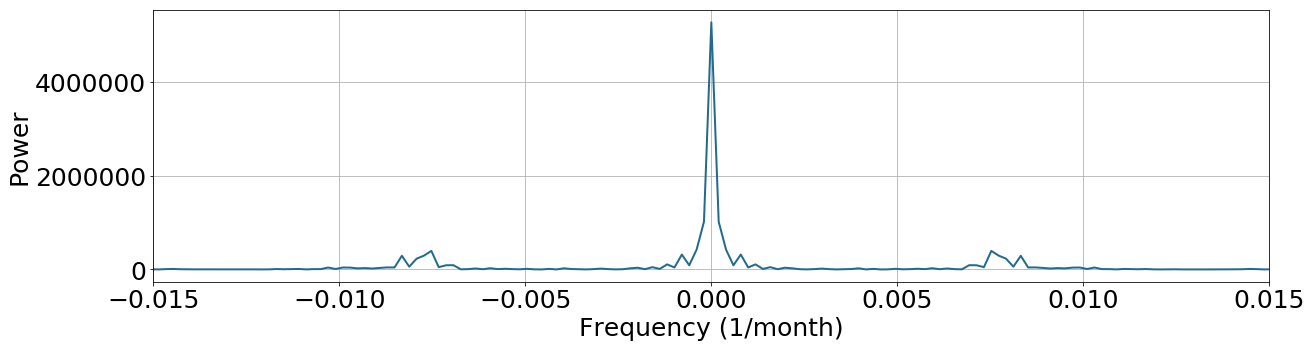

In [652]:
TCRpad = np.fft.fft(CRpad, norm='ortho')
freq = np.fft.fftfreq(len(CRpad), d = 1)

order = np.argsort(freq)

power = np.abs(TCRpad)**2

plt.figure(figsize=(20,5))
plt.plot(freq[order], power[order], color='#236B8E', linestyle='solid', linewidth=2);
plt.grid('on')
plt.xlabel('Frequency (1/month)', fontsize=25)
plt.ylabel('Power', fontsize=25)
plt.xlim(-0.015, 0.015)
plt.tick_params(labelsize=25)
plt.show()


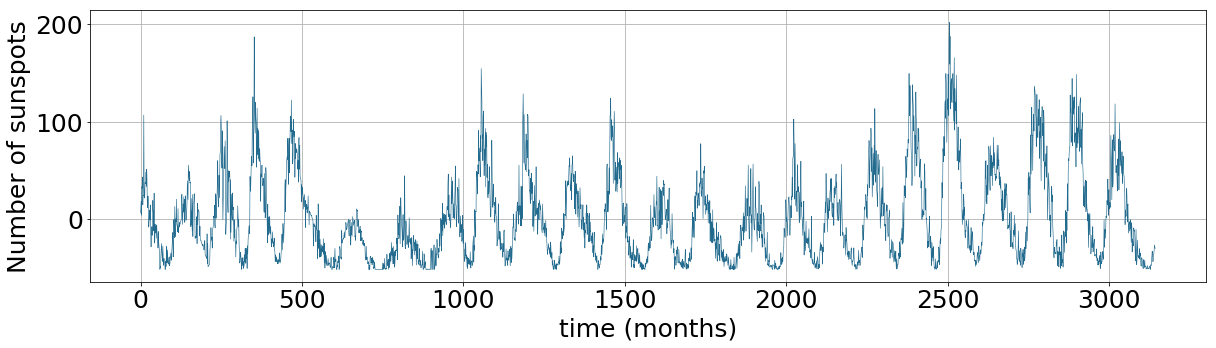

In [688]:
url = 'assign2/phys581-sunspots.txt'
data = np.genfromtxt( url, usecols=(0,1), names=['time', 'count_rate'] )

t = data['time']
CR = data['count_rate']

avg = np.average(CR)

CRmT = CR - avg

CRpadmT = np.pad(CRmT, 953, mode='constant', constant_values = 0)
tpad = np.pad(t, 953, mode='constant', constant_values = 0)

plt.figure(figsize=(20,5))
plt.plot(t, CRmT, color='#236B8E', linestyle='solid',  linewidth=0.6);
plt.grid('on')
plt.xlabel('time (months)', fontsize=25)
plt.tick_params(labelsize=25)
plt.ylabel('Number of sunspots', fontsize=25);
plt.show()


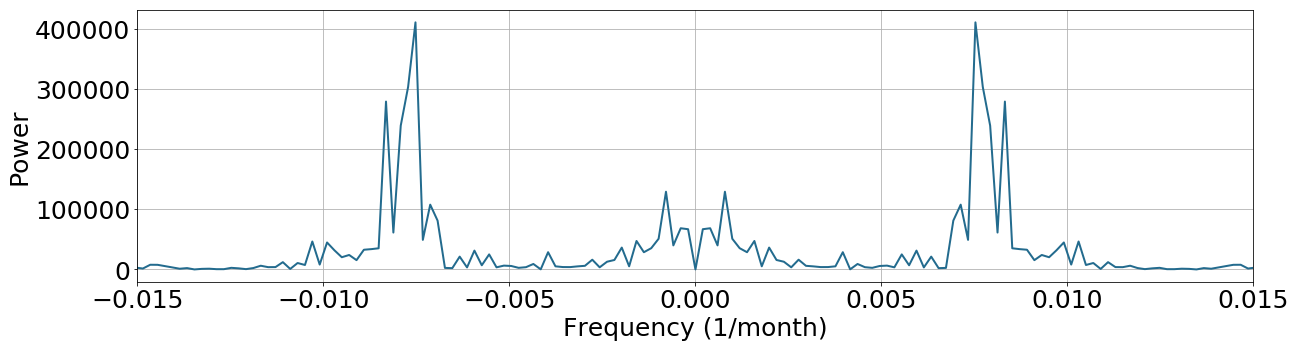

In [692]:
TCRpad2 = np.fft.fft(CRpadmT, norm='ortho')
freq = np.fft.fftfreq(len(CRpad), d = 1)

order = np.argsort(freq)

power = np.abs(TCRpad2)**2

plt.figure(figsize=(20,5))
plt.plot(freq[order], power[order], color='#236B8E', linestyle='solid', linewidth=2);
plt.grid('on')
plt.xlabel('Frequency (1/month)', fontsize=25)
plt.ylabel('Power', fontsize=25)
plt.xlim(-0.015, 0.015)
plt.tick_params(labelsize=25)
plt.show()

In [696]:
1/freq[np.where(power == power.max())]

array([-132.86842105])

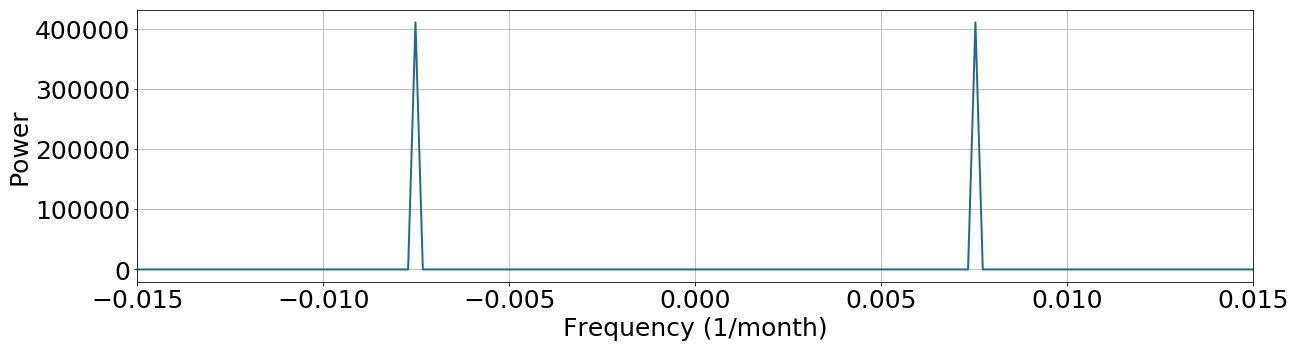

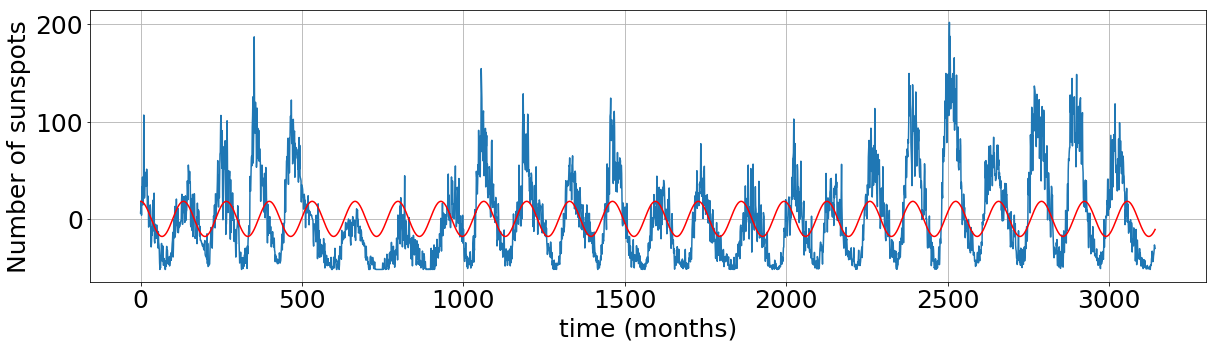

In [693]:

TCRpad2[np.where(power<410301)] = 0.000001
power = np.abs(TCRpad2)**2
CR_clean = np.fft.ifft(TCRpad2, norm='ortho')

plt.figure(figsize=(20,5))
plt.plot(freq[order], power[order], color='#236B8E', linestyle='solid', linewidth=2);
plt.grid('on')
plt.xlabel('Frequency (1/month)', fontsize=25)
plt.ylabel('Power', fontsize=25)
plt.xlim(-0.015, 0.015)
plt.tick_params(labelsize=25)
plt.show()

plt.figure(figsize=(20,5))
plt.plot(t, CR-avg, '-');
plt.plot(tpad[np.where(tpad !=0)], CR_clean.real[np.where(tpad !=0)], 'r-');
plt.grid('on')
plt.xlabel('time (months)', fontsize=25)
plt.tick_params(labelsize=25)
plt.ylabel('Number of sunspots', fontsize=25);
plt.show()

In [665]:
Max = (2550,2575)
Ind_max = power[order][Max[0]:Max[1]].argmax() + Max[0]
print("First max:", power[order][Ind_max], "| Index:", Ind_max, "| Period:", 1/freq[order][Ind_max], "| Frequency:", freq[order][Ind_max])



First max: 410302.944358 | Index: 2562 | Period: 132.868421053 | Frequency: 0.00752624282036


### 2.4 Applications to financial series

In [14]:
def auto_correlation(x):
    '''
    Finds the auto correlation of a digital signal
    '''
    avg = np.average(x)
    sigma2 = np.sum((x - avg)**2)
    return [np.sum((x-avg)*(np.roll(x, k)-avg))/sigma2 for k in range(len(x))]

def import_text(filename, separator):
    '''
    Source: https://stackoverflow.com/questions/482405/parsing-a-file-with-column-data-in-python
    '''
    for line in csv.reader(open(filename), delimiter=separator, 
                           skipinitialspace=True):
        if line:
            yield line
            
def cont_compounded_returns(series):
    return np.log(series[1:]/np.roll(series, 1)[1:])*100

In [19]:
months = {'Jan':0, 'Feb':31, 'Mar':59, 'Apr':90, 'May':120, 'Jun':151, 'Jul':181, 'Aug':212, 'Sep':243, 'Oct':273, 'Nov':304, 'Dec':334}

data = np.array([date for date in import_text(folder + 'phys581-stocks.txt', '	')])
names = data[:1][0, 1:]
dates = data[1:, 0]

data_arr = np.array(data.T[1:, 1:], dtype=np.float64)

times = [months[date[:3]]/365 + int(date[4:]) + 2000 for date in dates]

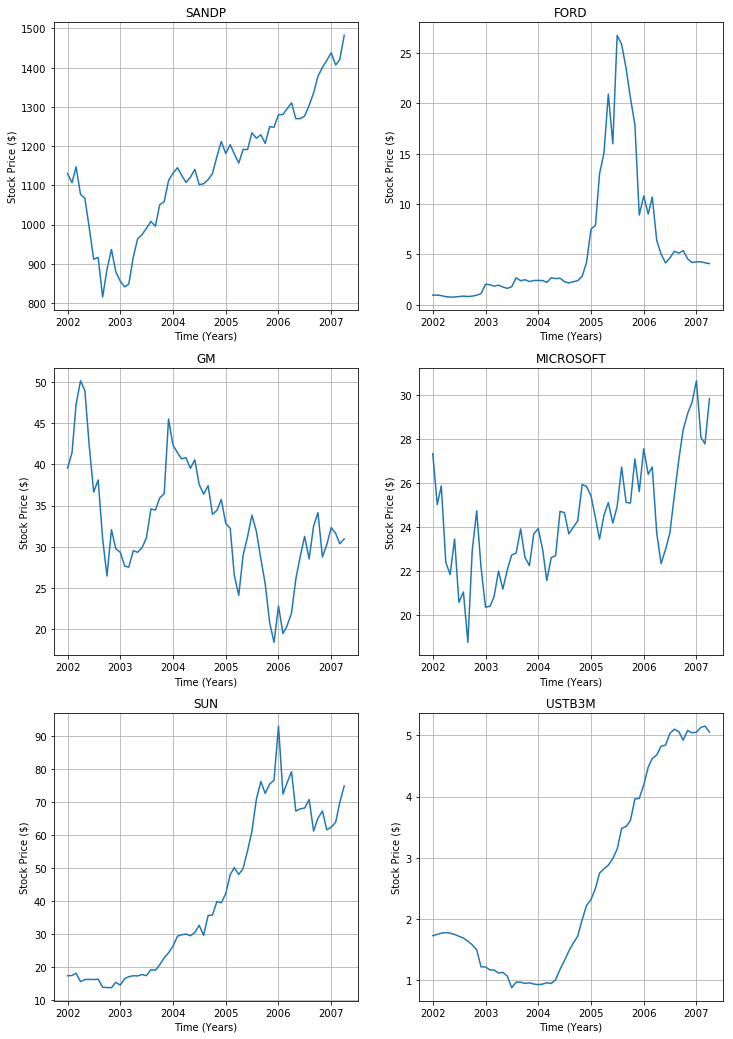

In [20]:
fig1, ax1 = plt.subplots(3, 2, figsize=(12,18))
ax1 = ax1.reshape(6)

for name, series, ax in zip(names, data_arr, ax1):
    ax.plot(times, series)
    ax.set_title(str(name))
    ax.set_ylabel('Stock Price ($)')
    ax.set_xlabel('Time (Years)')
    ax.grid()

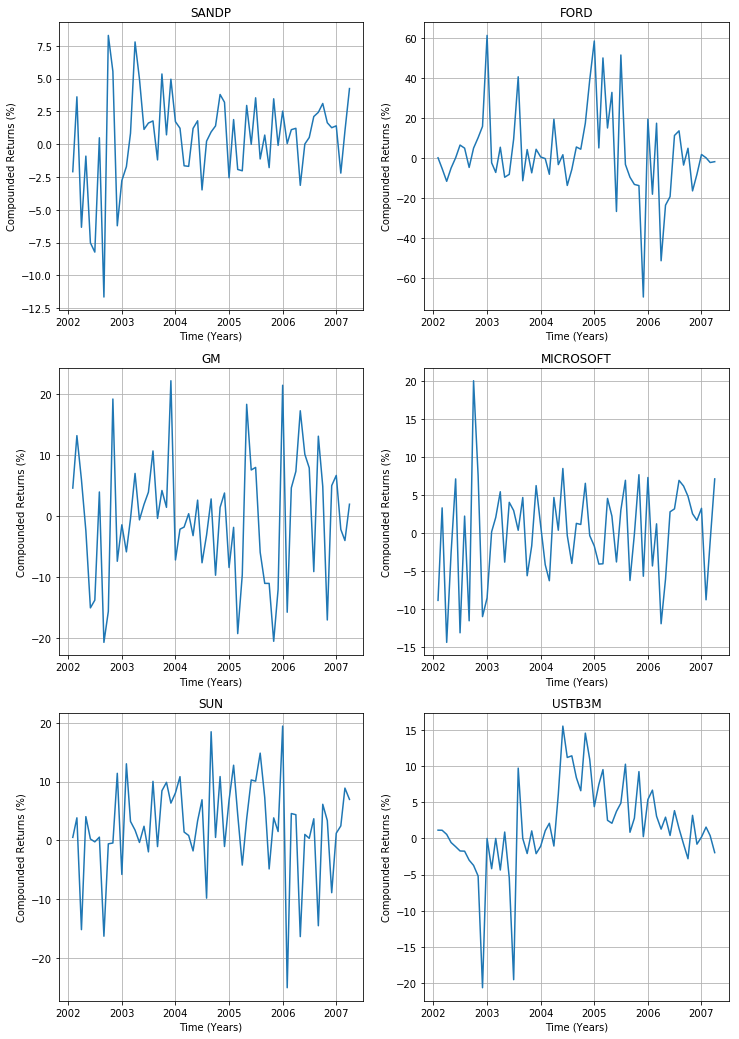

In [21]:
comp_returns = []
fig1, ax1 = plt.subplots(3, 2, figsize=(12,18))
ax1 = ax1.reshape(6)

for name, series, ax in zip(names, data_arr, ax1):
    returns = cont_compounded_returns(series)
    comp_returns.append(returns)
    
    ax.plot(times[1:], returns)
    ax.set_title(str(name))
    ax.set_ylabel('Compounded Returns (%)')
    ax.set_xlabel('Time (Years)')
    ax.grid()

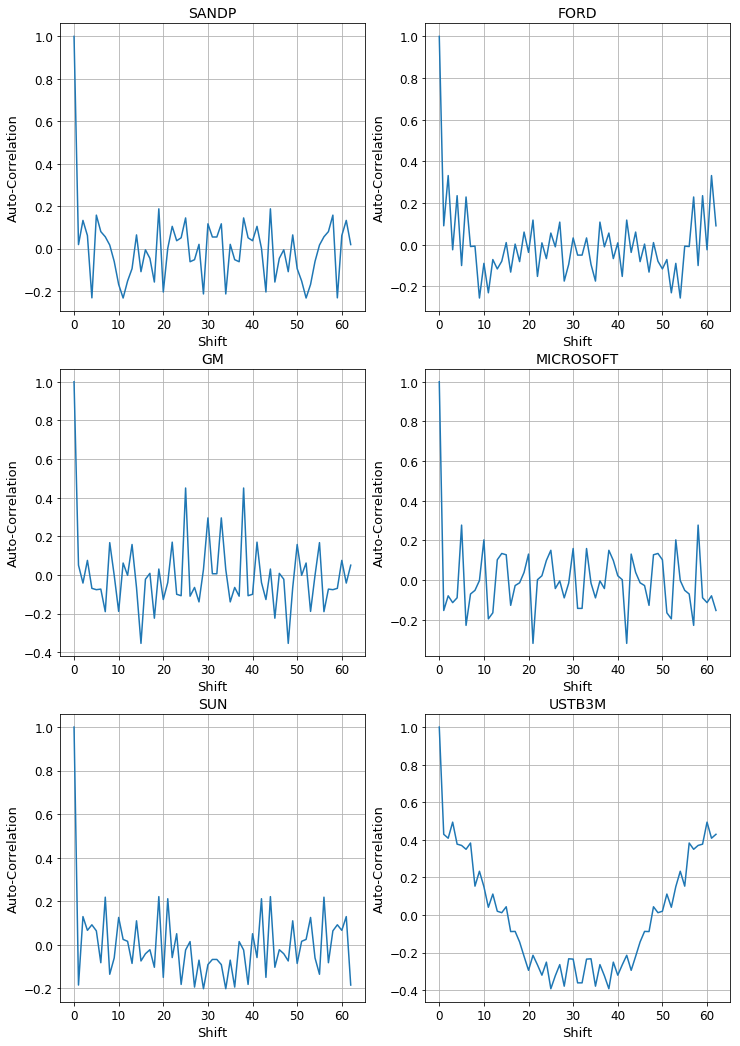

In [22]:
fig1, ax1 = plt.subplots(3, 2, figsize=(12,18))
axs = ax1.reshape(6)

autos = []

for name, series, ax in zip(names, comp_returns, axs):
    auto = auto_correlation(series)
    autos.append(auto)
    
    ax.plot(auto)
    ax.set_title(str(name), fontsize=14)
    ax.set_ylabel('Auto-Correlation', fontsize=13)
    ax.set_xlabel('Shift', fontsize=13)
    ax.grid()
    ax.tick_params(labelsize=12)

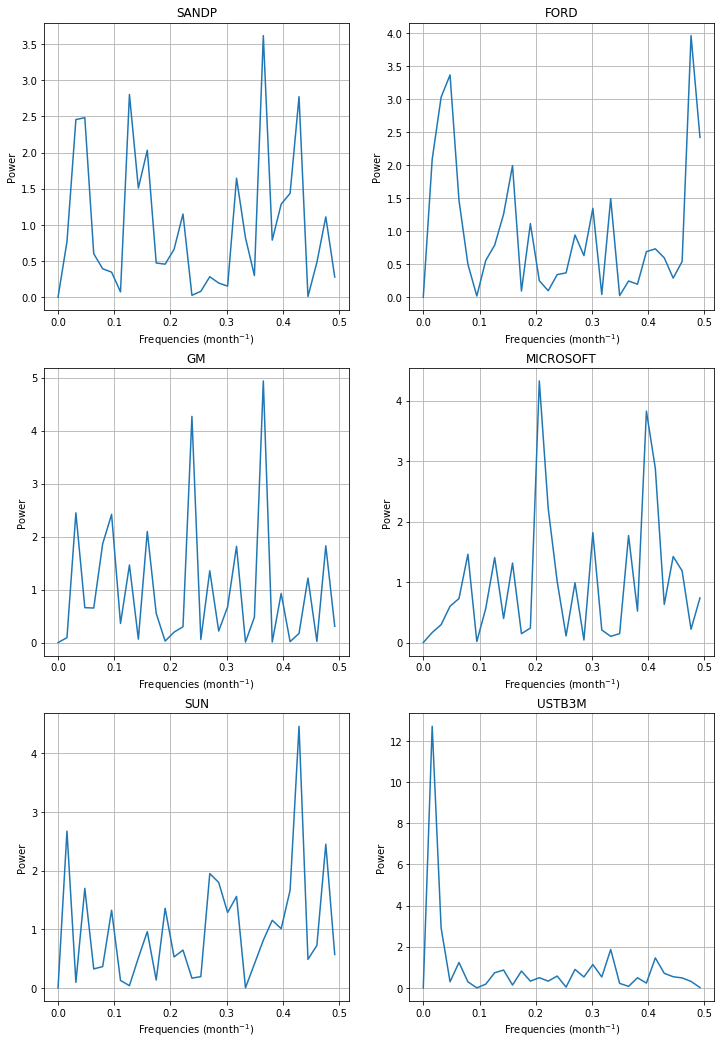

In [23]:
fig1, ax1 = plt.subplots(3, 2, figsize=(12,18))
axs = ax1.reshape(6)

for name, auto, ax in zip(names, autos, axs):
    ps = np.abs(np.fft.rfft(auto))
    
    ax.plot(np.fft.rfftfreq(len(auto), d=1), ps)
    ax.set_title(str(name))
    ax.set_ylabel('Power')
    ax.set_xlabel('Frequencies (month$^{-1}$)')
    ax.grid()

First max: 6896855831.76 | Index: 13 | Period: 78.7692307692 | Frequency: 0.0126953125


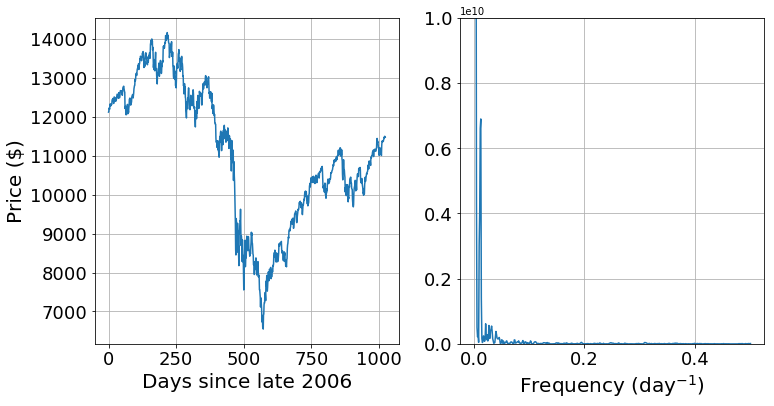

In [24]:
def hann_window(n):
    '''
    Hann window formula
    
    Parameters:
        n - (array-like) point(s) at which to calculate the hann window. 0 < n < 1
    Returns:
        (array-like) hann window at point(s) n
    '''
    return 0.5*(1-np.cos(2*np.pi*n))

dow_data = np.genfromtxt( folder + 'phys581-dow.txt', usecols=(0))
windowed_data = dow_data*hann_window(np.linspace(0, 1, len(dow_data)))
dow_power = (np.abs(np.fft.rfft(windowed_data))**2).real
dow_frequencies = np.fft.rfftfreq(len(dow_data), d=1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(dow_data)
axs[0].set_ylabel('Price ($)', fontsize=20)
axs[0].set_xlabel('Days since late 2006', fontsize=20)
axs[0].grid()
axs[0].tick_params(labelsize=18);

axs[1].plot(dow_frequencies, dow_power)
axs[1].set_xlabel('Frequency (day$^{-1}$)', fontsize=20)
axs[1].grid()
axs[1].set_ylim(0, 10**10)
axs[1].tick_params(labelsize=18);

print("First max:", dow_power[5:].max(), "| Index:", dow_power[5:].argmax()+5, "| Period:", 1/dow_frequencies[13], "| Frequency:", dow_frequencies[13])

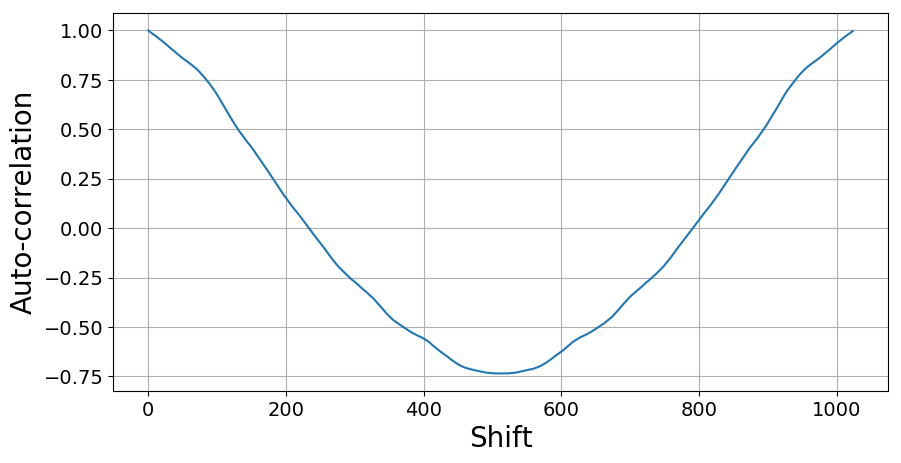

In [25]:
make_plot(y_label='Auto-correlation', x_label='Shift').plot(auto_correlation(dow_data));

### 2.5 Global Warming

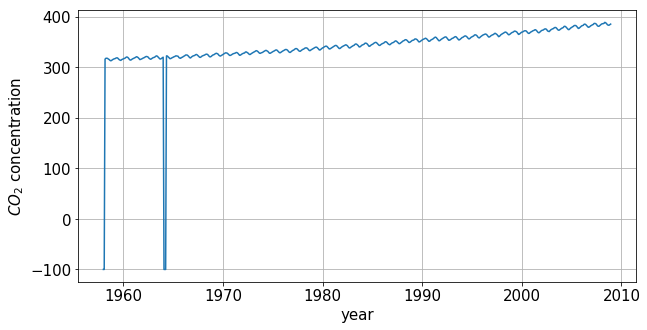

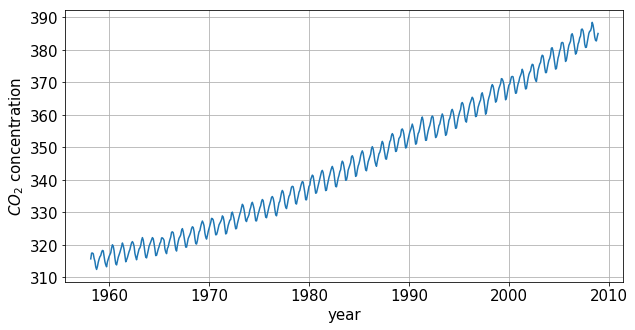

In [26]:
url = folder + 'phys581-co2.txt'
data = np.genfromtxt( url, usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12) )

year = np.arange(1958, 2009, 1/12)

data = data[:,1:]
data = data.reshape(data.shape[0]*data.shape[1])

plt.figure(figsize=(10,5))
plt.plot(year, data)
plt.grid('on')
plt.tick_params(labelsize=15)
plt.xlabel('year', fontsize=15)
plt.ylabel('$CO_2$ concentration', fontsize=15)

gooddates = np.where(data>0)
data = data[gooddates]
year = year[gooddates]

plt.figure(figsize=(10,5))
plt.plot(year, data)
plt.grid('on')
plt.tick_params(labelsize=15)
plt.xlabel('year', fontsize=15)
plt.ylabel('$CO_2$ concentration', fontsize=15)

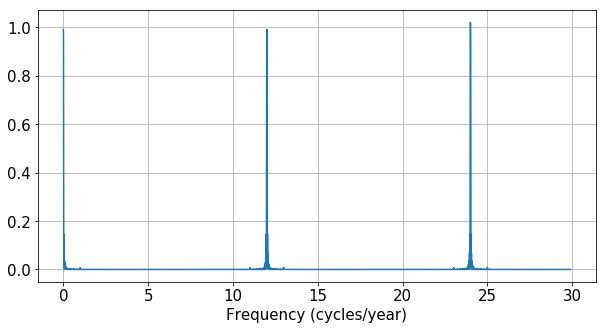

In [30]:
frequency, power = stats.LombScargle(year, data).autopower()

plt.figure(figsize=(10,5))
plt.plot(frequency, power)
plt.grid('on')
plt.tick_params(labelsize=15)
plt.xlabel('Frequency (cycles/year)', fontsize=15);

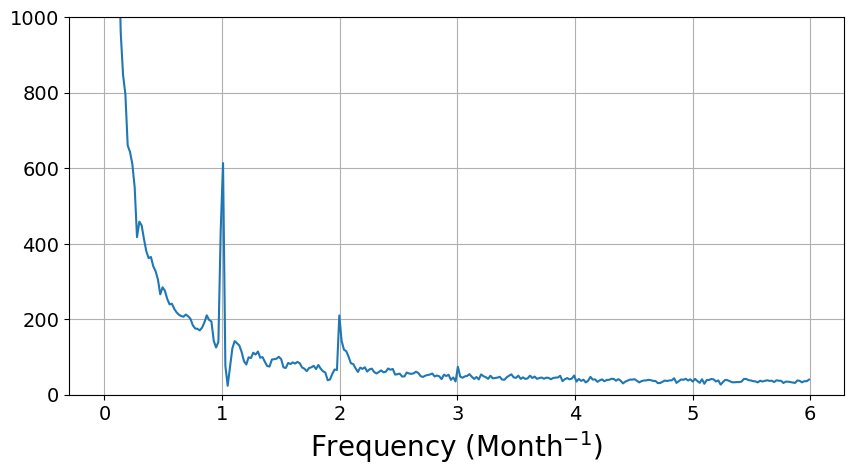

In [31]:
Tdata = np.fft.rfft(data)
freq = np.fft.rfftfreq(len(data), d=1/12)

make_plot(x_label='Frequency (Month$^{-1}$)', y_lim=(0,1000)).plot(freq, np.abs(Tdata));

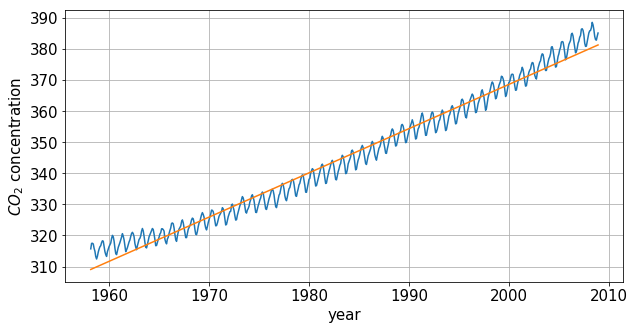

In [32]:
coefs = np.polyfit(year, data, 1)
fitfunc = np.polyval(coefs, year)

plt.figure(figsize=(10,5))
plt.plot(year, data)
plt.plot(year, fitfunc)
plt.grid('on')
plt.tick_params(labelsize=15)
plt.xlabel('year', fontsize=15)
plt.ylabel('$CO_2$ concentration', fontsize=15);

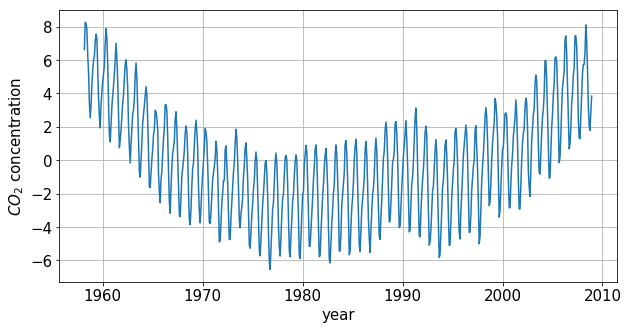

In [33]:
data_mtrend = data - fitfunc

plt.figure(figsize=(10,5))
plt.plot(year, data_mtrend)
plt.grid('on')
plt.tick_params(labelsize=15)
plt.xlabel('year', fontsize=15)
plt.ylabel('$CO_2$ concentration', fontsize=15);

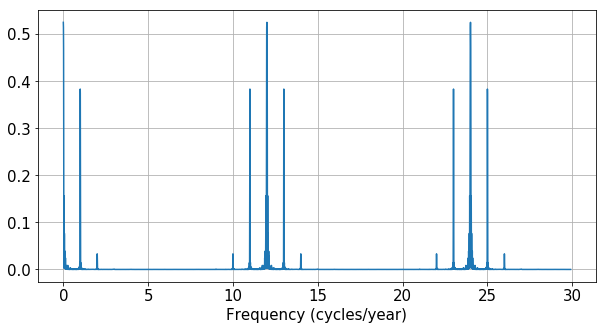

In [37]:
frequency, power = stats.LombScargle(year, data_mtrend).autopower(method='chi2')

plt.figure(figsize=(10,5))
plt.plot(frequency, power)
plt.grid('on')
plt.tick_params(labelsize=15)
plt.xlabel('Frequency (cycles/year)', fontsize=15);